In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda
import datetime
import salem
from salem import get_demo_file, DataLevels, GoogleVisibleMap, Map
import shapely.geometry as shpg
import glob
import pickle as pkl
import os
from scipy.stats import binned_statistic_2d


pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [6]:
months_n = (5,8)
months_s = (11,2)

 
MREGIONS = {
 'GPlains' : [[-100,-90,32,47], 'nam', -6, (1,7), months_n, (1,12)], # # 18  
 'china' : [[105,115,25,40], 'asia', 8 , (1,7), months_n, (1,12)], # 4
 'india' : [[70,90, 5,30], 'asia', 5, (1,7), months_n, (1,12)], # 7
 'WAf' : [[-18,25,4,25], 'spac', 0, (1,7), months_n, (1,12)], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'australia' : [[120,140,-23, -11], 'asia', 9, (11,3),months_s, (1,12)], # 3
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), months_s, (11,3)], # 10
 'sub_SA' : [[-68,-47, -40, -20.5], 'spac', -4, (11,3), months_s, (1,12)] , # 16
# 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5, (1,12), (1,12), (1,12)], # 17


}

In [8]:
rdics = {}
for regs in MREGIONS.keys():
    for ids, y in enumerate(range(2000,2018)):
        test = pd.read_csv('/media/ck/LStorage/global_water/save_files/'+regs+'_initTime__mcs_tracks_extc_'+str(y)+'0101_'+str(y)+'1231.csv')
        if ids == 0:
            test2 = pd.DataFrame(test)
        else :
            test2 = pd.concat([test2, test])
    rdics[regs] = test2

In [63]:
snapdics = {}
for regs in MREGIONS.keys():
    for ids, y in enumerate(range(2000,2021)):
        #'ipdb.set_trace()
        try:
            test = pd.read_csv(glob.glob('/media/ck/LStorage/global_water/MCS_5000km2_tables/base_tables_tir-prcp/'+regs+'/'+str(y)+'*.csv')[0])
        except:
            ipdb.set_trace()
    #      
        if ids == 0:
            test2 = pd.DataFrame(test)
        else :
            test2 = pd.concat([test2, test])
            
    test2 = test2[(test2['precipitation_max']>=2) & (test2['tmin']>-120)]
    snapdics[regs] = test2

In [26]:
waf_track = rdics['WAf']

In [64]:
waf_snap = snapdics['WAf']

In [40]:
waf_track.keys()

Index(['length', 'mcs_length', 'mcs_type', 'starttrackresult',
       'endtrackresult', 'base_time', 'mcs_status', 'meanlat', 'meanlon',
       'core_area', 'ccs_area', 'mintb', 'meantb', 'ccs_meantb', 'core_meantb',
       'speed', 'direction1', 'direction-1', 'direction-2', 'direction0',
       'uspeed', 'vspeed', 'trackresult', 'cloudnumber', 'majoraxislength',
       'eccentricity', 'pf_length', 'pf_mcsstatus', 'pf_heavyrainratio',
       'total_rain', 'total_heavyrain', 'rainrate_heavyrain', 'npf',
       'pf_landfrac', 'pf_area1', 'pf_area2', 'pf_area3', 'pf_lon1', 'pf_lon2',
       'pf_lon3', 'pf_lat1', 'pf_lat2', 'pf_lat3', 'pf_rainrate1',
       'pf_rainrate2', 'pf_rainrate3', 'pf_maxrainrate1', 'pf_maxrainrate2',
       'pf_maxrainrate3', 'pf_accumrain1', 'pf_accumrain2', 'pf_accumrain3',
       'pf_accumrainheavy1', 'pf_accumrainheavy2', 'pf_accumrainheavy3',
       'pf_majoraxislength1', 'pf_majoraxislength2', 'pf_majoraxislength3',
       'pf_aspectratio1', 'pf_aspectratio

In [72]:
waf_snap.keys()

Index(['Unnamed: 0', 'date', 'month', 'hour', 'minute', 'year', 'day', 'area',
       '70area', 'tmin', 'minlon', 'minlat', 'maxlon', 'maxlat', 'clon',
       'clat', 'tminlon', 'tminlat', 'tmean', 'tp1', 'tp99', 'stormID',
       'precipitation_mean', 'precipitation_max', 'precipitation_p95',
       'precipitation_p99'],
      dtype='object')

In [73]:
waf_snap.area.min()

5000

In [61]:
len(waf_snap['precipitation_max'])

918006

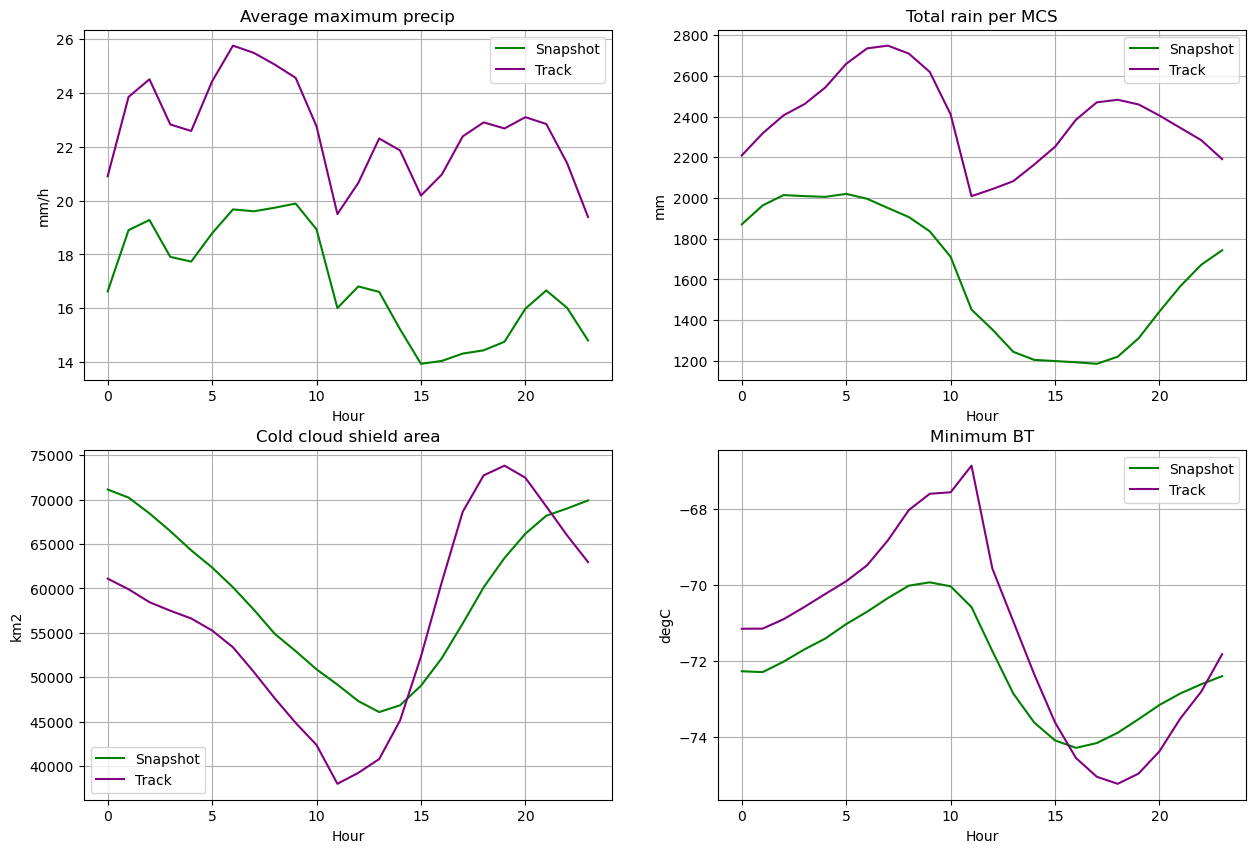

In [81]:
data = waf_snap
sensitivity_data = waf_track

f = plt.figure(figsize=(15, 10))
ax = f.add_subplot(2,2,1)
hours = data.groupby('hour')['precipitation_max'].mean()#.quantile(0.95)
plt.plot(hours.index, hours.values, label='Snapshot'.format(len(hours)), color='green')

sensitivity_hours = sensitivity_data.groupby('hour')['pf_maxrainrate1'].mean() #.quantile(0.95)
plt.plot(sensitivity_hours.index, sensitivity_hours.values, label='Track'.format(len(sensitivity_hours)), color='purple')
#####

plt.xlabel('Hour')
plt.ylabel('mm/h')
plt.title('Average maximum precip')
plt.legend()
plt.grid(True)

# ##############################

ax = f.add_subplot(2,2,2)
hours = data.groupby('hour')['precipitation_mean'].mean() * data.groupby('hour')['area'].mean()/50 #.quantile(0.95)*1.5**2
plt.plot(hours.index, hours.values, label='Snapshot'.format(len(hours)), color='green')
#####


sensitivity_hours = sensitivity_data.groupby('hour')['total_rain'].mean() #.quantile(0.95)*1.5**2
plt.plot(sensitivity_hours.index, sensitivity_hours.values, label='Track'.format(len(sensitivity_hours)), color='purple')
############


plt.xlabel('Hour')
plt.ylabel('mm')
plt.title('Total rain per MCS')
plt.legend()
plt.grid(True)

# ##############################

# ##############################

ax = f.add_subplot(2,2,3)
hours = data.groupby('hour')['area'].mean()*2 #.quantile(0.95)*1.5**2
plt.plot(hours.index, hours.values, label='Snapshot'.format(len(hours)), color='green')
#####


sensitivity_hours = sensitivity_data.groupby('hour')['core_area'].mean() #.quantile(0.95)*1.5**2
plt.plot(sensitivity_hours.index, sensitivity_hours.values, label='Track'.format(len(sensitivity_hours)), color='purple')
############


plt.xlabel('Hour')
plt.ylabel('km2')
plt.title('Cold cloud shield area')
plt.legend()
plt.grid(True)

# ##############################
# ##############################

ax = f.add_subplot(2,2,4)
hours = data.groupby('hour')['tmin'].mean() #.quantile(0.95)*1.5**2
plt.plot(hours.index, hours.values, label='Snapshot'.format(len(hours)), color='green')
#####


sensitivity_hours = sensitivity_data.groupby('hour')['mintb'].mean()-273.15 #.quantile(0.95)*1.5**2
plt.plot(sensitivity_hours.index, sensitivity_hours.values, label='Track'.format(len(sensitivity_hours)), color='purple')
############


plt.xlabel('Hour')
plt.ylabel('degC')
plt.title('Minimum BT')
plt.legend()
plt.grid(True)

# ##############################


plt.legend()
plt.grid(True)

plt.show()

<AxesSubplot:ylabel='Frequency'>

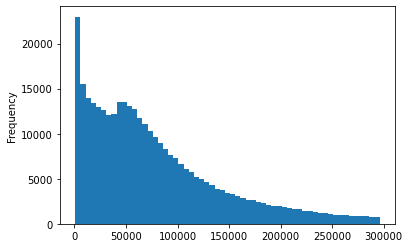

In [36]:
f = plt.figure(figsize=(15, 10))
ax = f.add_subplot(2,2,1)
hours = data.groupby('hour')['area'].quantile(0.80)*1.5**2
plt.plot(hours.index, hours.values, label='Day1 (n={})'.format(len(hours)), color='green')
#####


sensitivity_hours = sensitivity_data.groupby('hour')['area'].quantile(0.80)*1.5**2
plt.plot(sensitivity_hours.index, sensitivity_hours.values, label='Day2 (n={})'.format(len(sensitivity_hours)), color='purple')
############


control_hours = control_data.groupby('hour')['area'].quantile(0.80)*1.5**2
plt.plot(control_hours.index, control_hours.values, label='Control (n={})'.format(len(control_hours)), color='black')

plt.xlabel('Hour')
plt.ylabel('Percentile cloud size (km2)')
plt.title('p80 cloud size (>50km2, <-50C)')
plt.legend()
plt.grid(True)

##############################

ax = f.add_subplot(2,2,2)
hours = data.groupby('hour')['area'].quantile(0.95)*1.5**2
plt.plot(hours.index, hours.values, label='Day1 (n={})'.format(len(hours)), color='green')
#####


sensitivity_hours = sensitivity_data.groupby('hour')['area'].quantile(0.95)*1.5**2
plt.plot(sensitivity_hours.index, sensitivity_hours.values, label='Day2 (n={})'.format(len(sensitivity_hours)), color='purple')
############


control_hours = control_data.groupby('hour')['area'].quantile(0.95)*1.5**2
plt.plot(control_hours.index, control_hours.values, label='Control (n={})'.format(len(control_hours)), color='black')

plt.xlabel('Hour')
plt.ylabel('Percentile cloud size (km2)')
plt.title('p95 cloud size (>50km2, <-50C)')
plt.legend()
plt.grid(True)

##############################
##############################

ax = f.add_subplot(2,2,3)
hours = data.groupby('hour')['area'].quantile(0.99)*1.5**2
plt.plot(hours.index, hours.values, label='Day1 (n={})'.format(len(hours)), color='green')
#####


sensitivity_hours = sensitivity_data.groupby('hour')['area'].quantile(0.99)*1.5**2
plt.plot(sensitivity_hours.index, sensitivity_hours.values, label='Day2 (n={})'.format(len(sensitivity_hours)), color='purple')
############


control_hours = control_data.groupby('hour')['area'].quantile(0.99)*1.5**2
plt.plot(control_hours.index, control_hours.values, label='Control (n={})'.format(len(control_hours)), color='black')

plt.xlabel('Hour')
plt.ylabel('Percentile cloud size (km2)')
plt.title('p99 cloud size (>50km2, <-50C)')
plt.legend()
plt.grid(True)

##############################


###############################


ax = f.add_subplot(2,2,4)
hours = data.groupby('hour')['area'].sum()
plt.plot(hours.index, hours.values, label='Day1 (n={})'.format(len(hours)), color='green')
#####


sensitivity_hours = sensitivity_data.groupby('hour')['area'].sum()
plt.plot(sensitivity_hours.index, sensitivity_hours.values, label='Day2 (n={})'.format(len(sensitivity_hours)), color='purple')
############


control_hours = control_data.groupby('hour')['area'].sum()
plt.plot(control_hours.index, control_hours.values, label='Control (n={})'.format(len(control_hours)), color='black')

plt.xlabel('Hour')
plt.ylabel('Total area cloudy pixels')
plt.title('Total cloud area (>50km2, <-50C)')
plt.legend()
plt.grid(True)

plt.show()

In [37]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask] 
    sh = np.array(dic['shear'])[mask]  # 925-650 hPa shear
    umin = np.array(dic['u650'])[mask] # minimum 650hPa zonal wind 
    umax = np.array(dic['u925'])[mask] # maximum 925hPa zonal wind
    qq = np.array(dic['q925'])[mask]   # 925hPa spec humidity
    qup = np.array(dic['q650'])[mask]  # 650hPa spec humidity
    tlow = np.array(dic['t925'])[mask] # 925hPa temperature
    tt = np.array(dic['tmin'])[mask]   # minimum cloud top temperature
    ttm = np.array(dic['tmean'])[mask] # mean cloud top temperature
    month = np.array(dic['month'])[mask] 
    hour = np.array(dic['hour'])[mask]
    year = np.array(dic['year'])[mask]
   # minute = np.array(dic['minute'])[mask]
    day = np.array(dic['day'])[mask]
    date = np.array(dic['date'])[mask]
    area = np.array(dic['area'])[mask] # -50C storm area
    lat = np.array(dic['clat'])[mask] # location of minimum temperature
    lon = np.array(dic['clon'])[mask] # location of minimum temperature
    tcwv = np.array(dic['tcwv'])[mask] # total column water vapour
    rh = np.array(dic['rh925'])[mask] # 925hPa relative humidity
    #pall = np.array(dic['p'])[mask] # precipitation field within -50C cloud area


    obs_pcp = {
        'prcp' : pp,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        'shear' : sh*-1,
        'month' : month,    
        'hour' : hour,
        'year' : year,
      #  'minute' : minute,
        'day' : day,
        'date' : date,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        'tcwv' : tcwv,
        'lat' : lat,
        'lon' : lon,
        #'pall' : pall
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [38]:
file_path = cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-10N_10W10E_p15_ERA0.7_fullYear*.p'

In [39]:
ds = glob.glob(file_path)

for ids, dss in enumerate(ds):
    data = pkl.load( open (dss, 'rb'))

    obs_gpmf_h = create_dic(data)
    if ids > 0:
        obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
    else:
        obs_gpmf = obs_gpmf_h

    del data

In [40]:
obs = obs_gpmf[obs_gpmf.prcp>5]

In [46]:
obs = pd.DataFrame(obs)

Text(0.5, 1.0, 'Storm area West Africa | 5000km2 min, -50C')

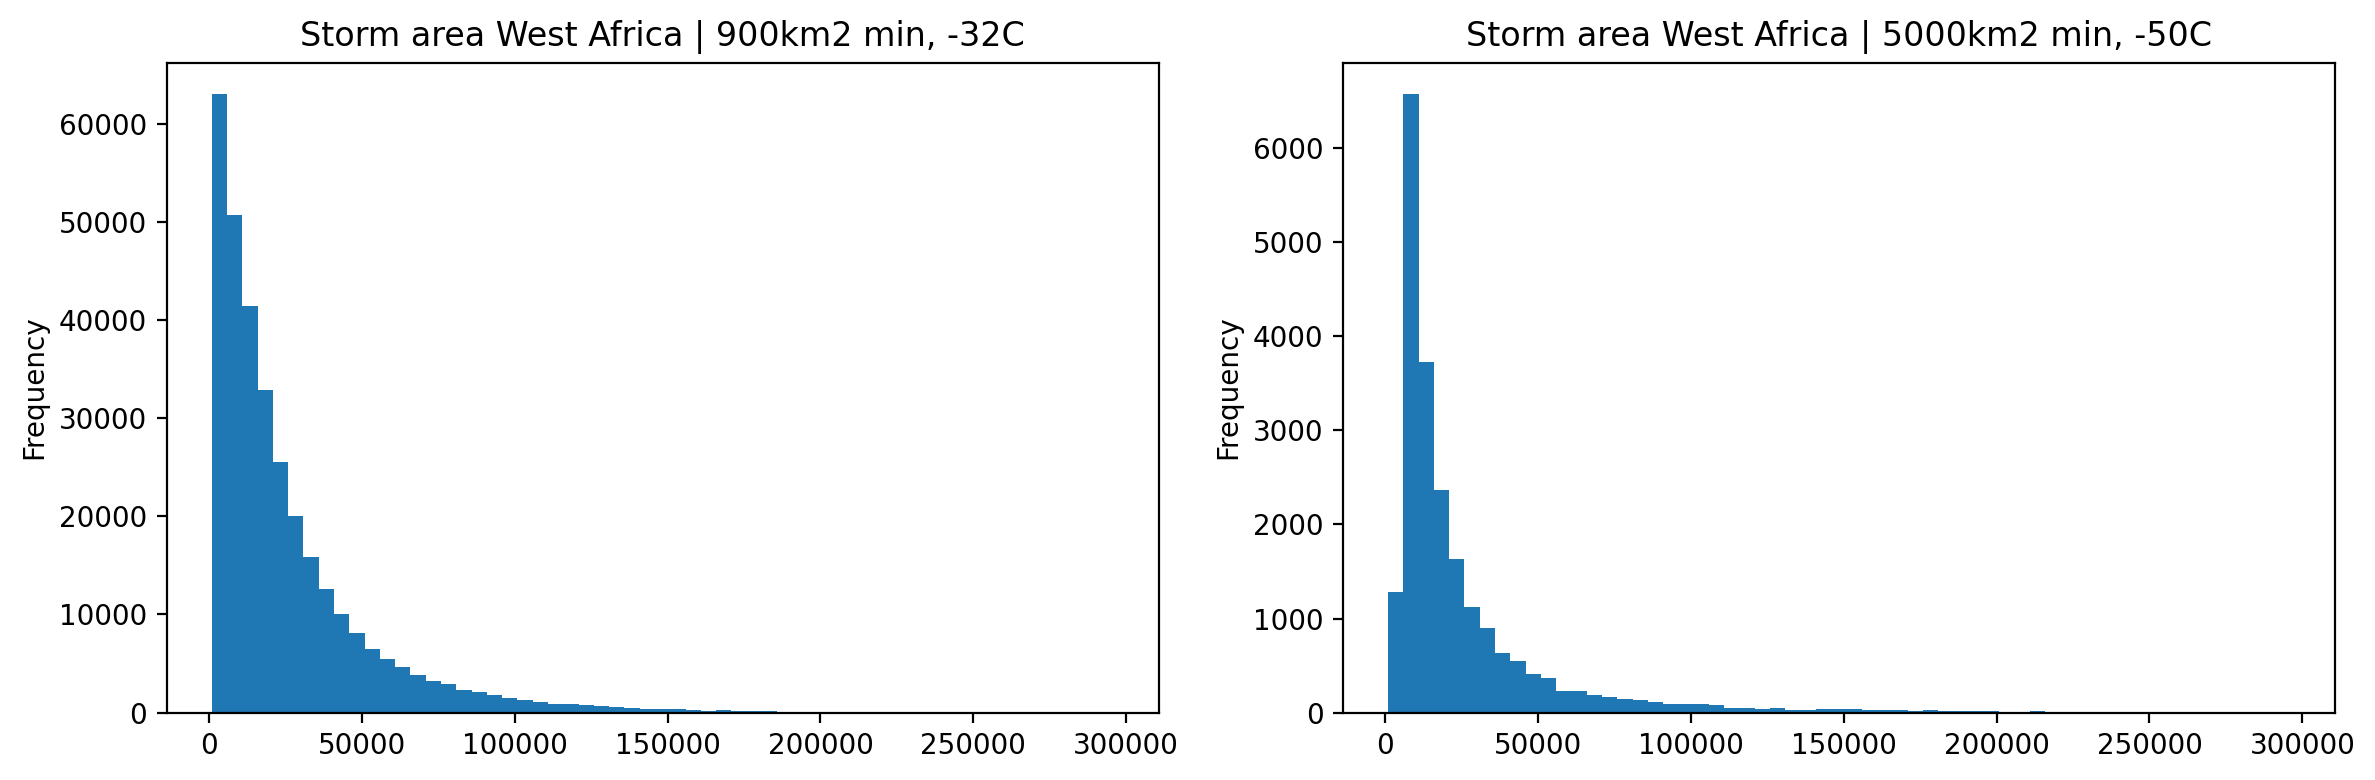

In [124]:
f = plt.figure(figsize=(12,4), dpi=200)
ax = f.add_subplot(121)
(rdics['WAf'])['pf_area1'].plot.hist(bins=range(900,300000,5000)) # ccs_area, pf_area1
plt.title('Storm area West Africa | 900km2 min, -32C')

ax = f.add_subplot(122)
(obs['area']).plot.hist(bins=range(900,300000,5000))
plt.tight_layout()
plt.title('Storm area West Africa | 5000km2 min, -50C')

<AxesSubplot:ylabel='Frequency'>

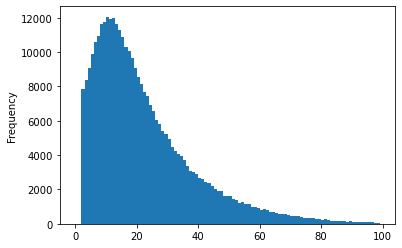

In [30]:
(rdics['WAf'])['pf_maxrainrate1'].plot.hist(bins=range(0,100,1))

In [79]:
a = rdics['WAf']['mintb']
b = rdics['WAf']['pf_maxrainrate1']
plt.scatter(a,b)

NameError: name 'x' is not defined

In [80]:
rdics['WAf']['mintb']-273.15

0       -82.64637
1       -82.15000
2       -79.26887
3       -81.14956
4       -76.04377
           ...   
18467   -72.94947
18468   -70.57601
18469   -65.93748
18470   -57.16874
18471   -45.38906
Name: mintb, Length: 355643, dtype: float64

In [91]:
from endgame import hist2d


/home/ck/pythonWorkspace/proj_CEH/endgame/hist2d.py:437: RuntimeWarning: invalid value encountered in true_divide
  outdic['y'].append(np.sum(yvar[mask]>gt)/float(np.sum(np.isfinite(yvar[mask]))))


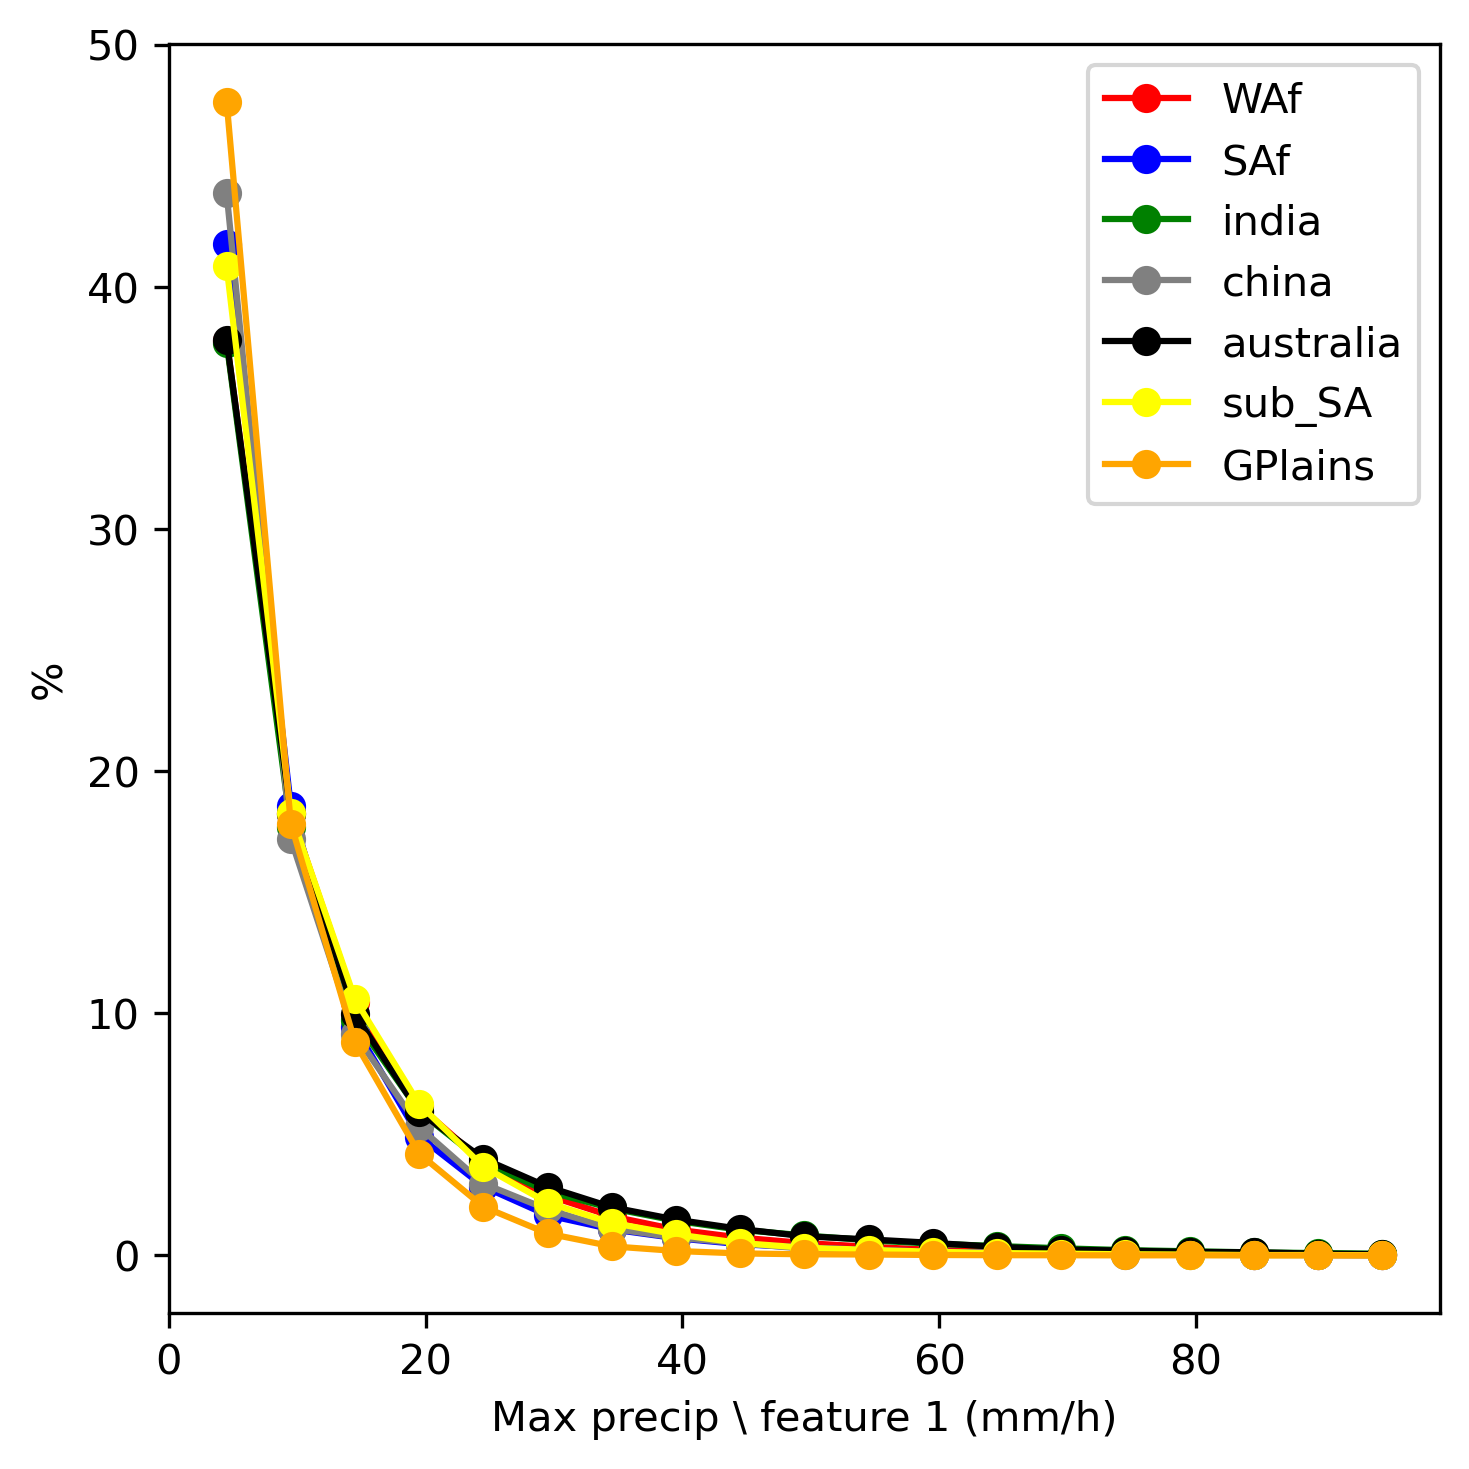

In [122]:
f= plt.figure(figsize=(5,5), dpi=300)
ax = f.add_subplot(111)
colors = ['r','b', 'g', 'grey', 'k', 'yellow', 'orange', 'purple']
for ids, regs in enumerate(MREGIONS.keys()):

    outdic = hist2d.basic_1d_binning((rdics[regs]['pf_maxrainrate2']).values, np.arange(2,100,5), percentage=True)
    #print(outdic.keys())
    plt.plot(outdic['xbins'], np.array(outdic['nb'])*100, '-o', color=colors[ids], label=regs)
    
    #ax.set_ylim(0,1)
    plt.ylabel('%')
    plt.xlabel('Max precip \ feature 1 (mm/h)')
plt.tight_layout()
plt.legend()
f.savefig('/home/ck/Desktop/lmcs/precip_feat1_dist.jpg')

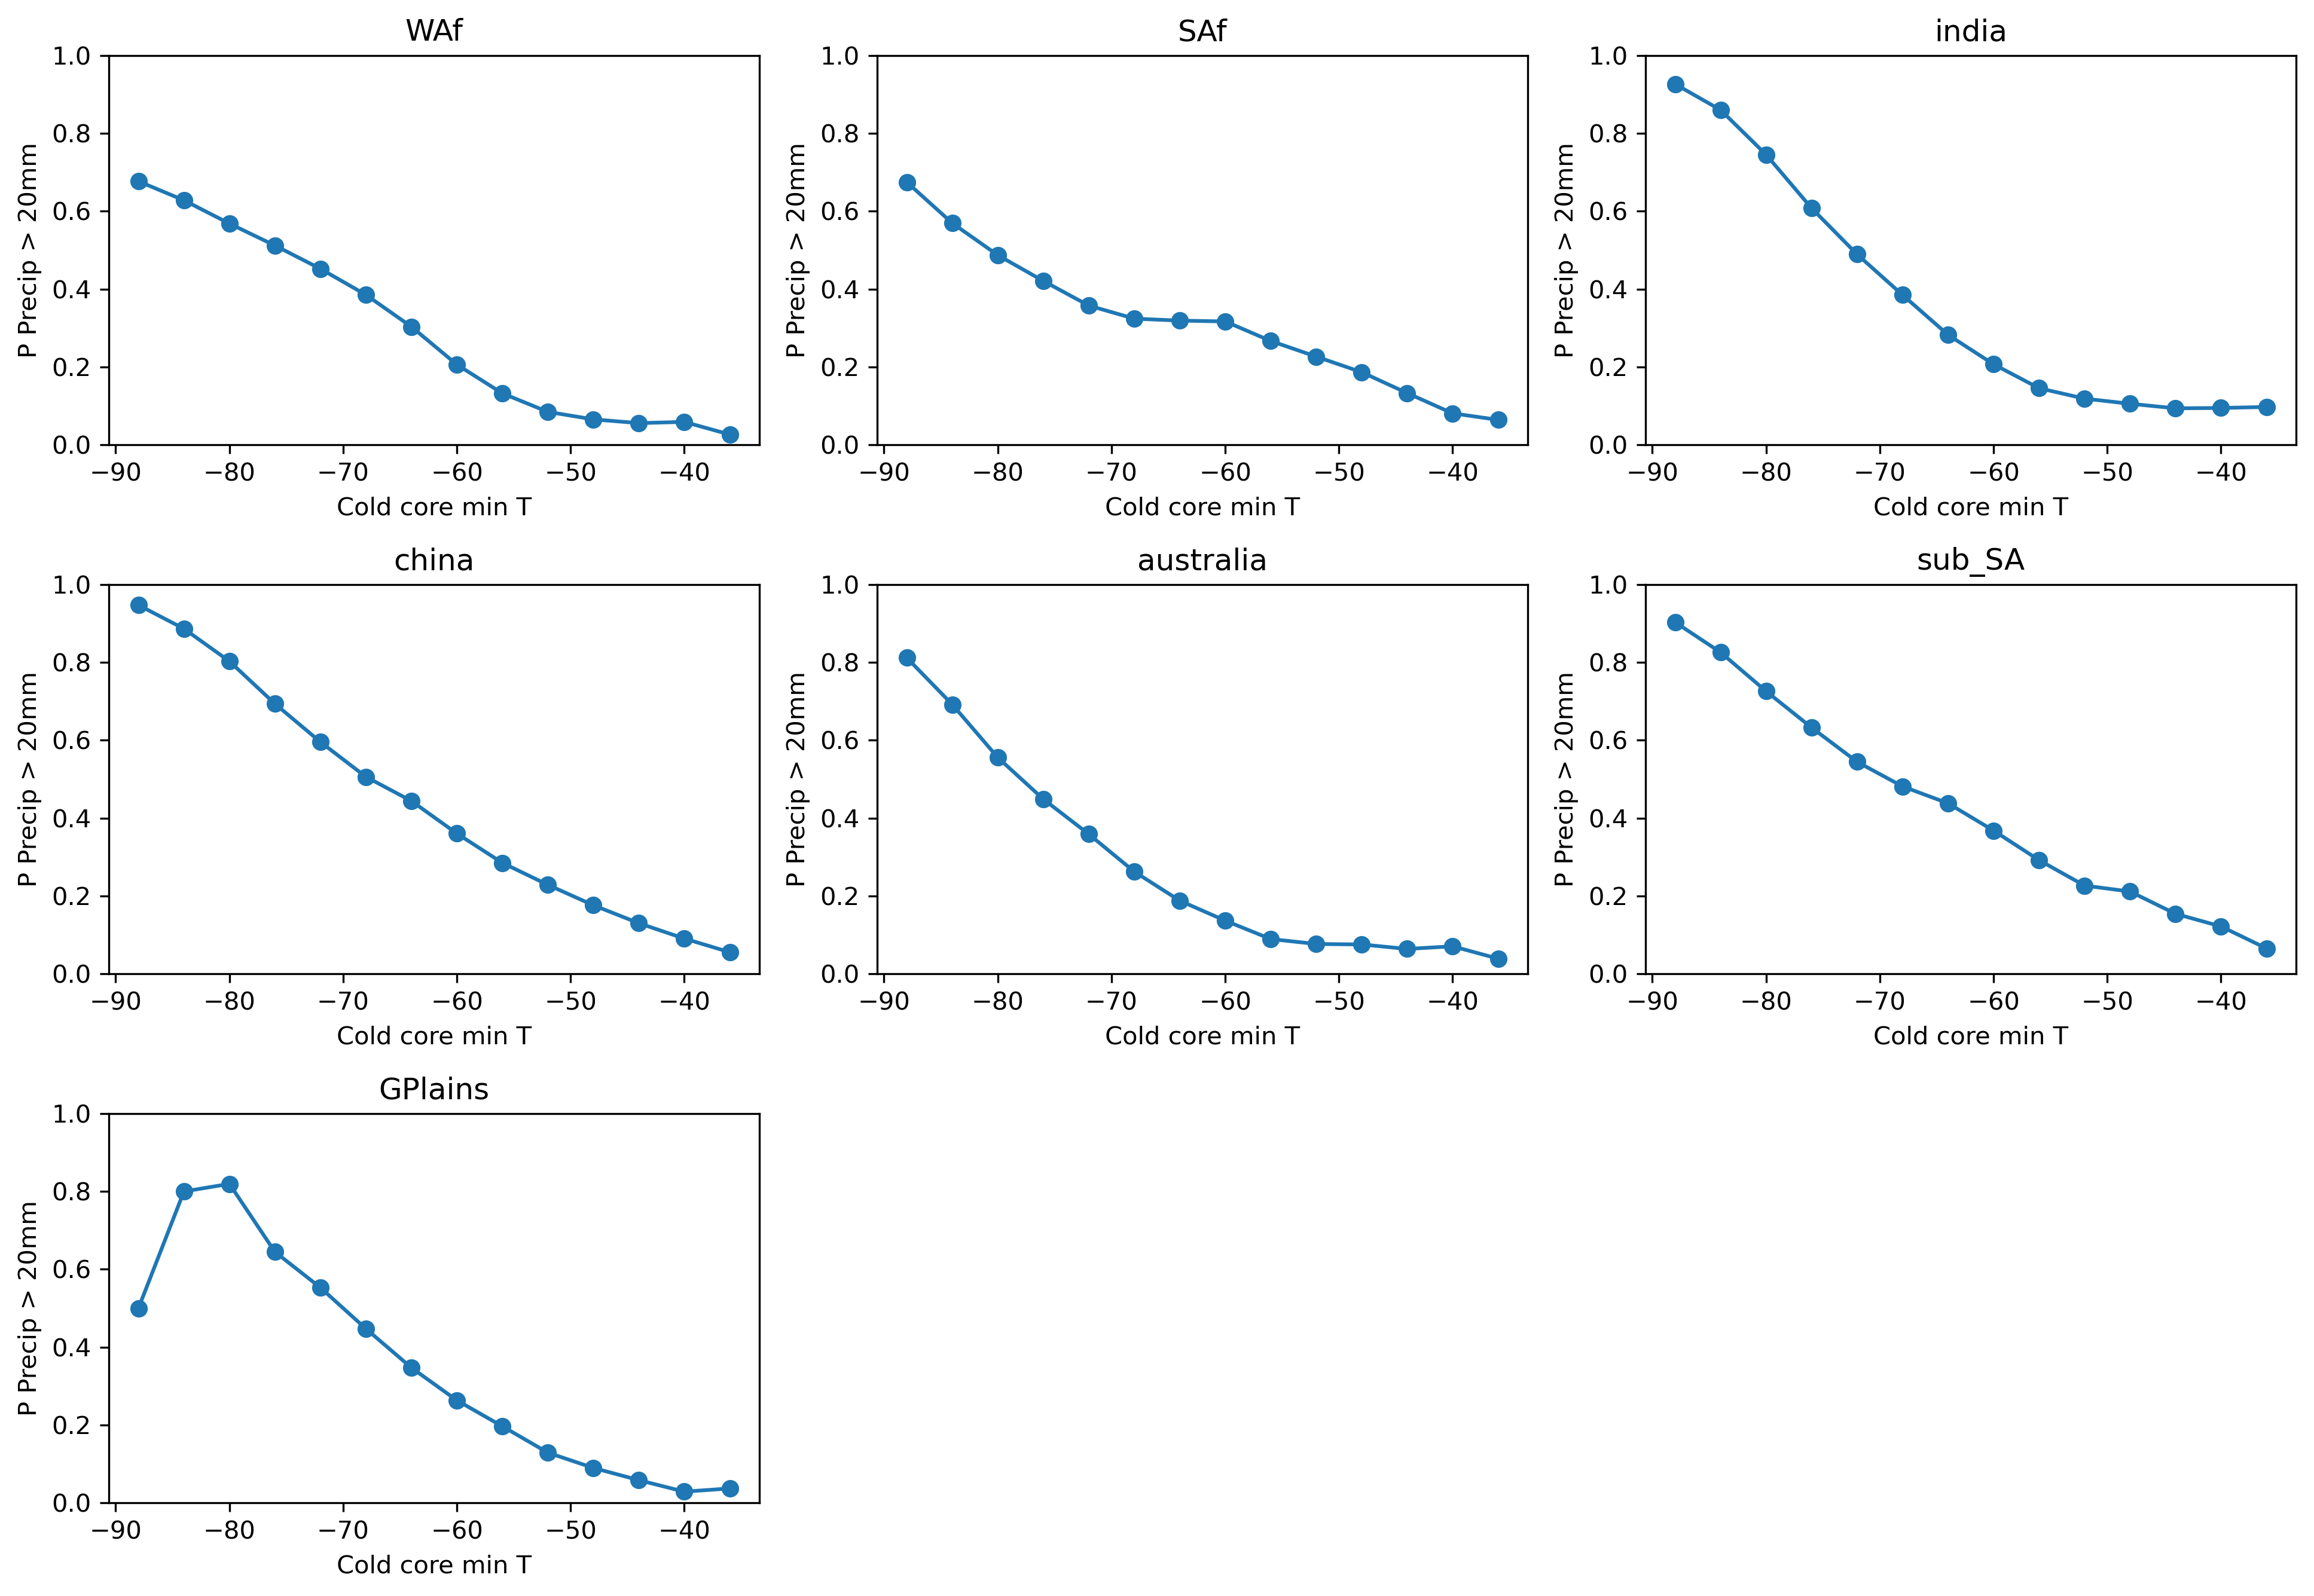

In [103]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    outdic = hist2d.var2_binning_threshold((rdics[regs]['mintb']-273.15).values, (rdics[regs]['pf_maxrainrate1']).values, np.arange(-90,-30,4), gt=20)
    plt.plot(outdic['xbins'], outdic['y'], '-o')
    plt.title(regs)
    ax.set_ylim(0,1)
    plt.ylabel('P Precip > 20mm')
    plt.xlabel('Cold core min T')
plt.tight_layout()
f.savefig('/home/ck/Desktop/lmcs/20mm_precip_vs_CC_minT.jpg')

In [11]:
from utils import u_statistics as u_stats

18
16
13
10
9
22
24


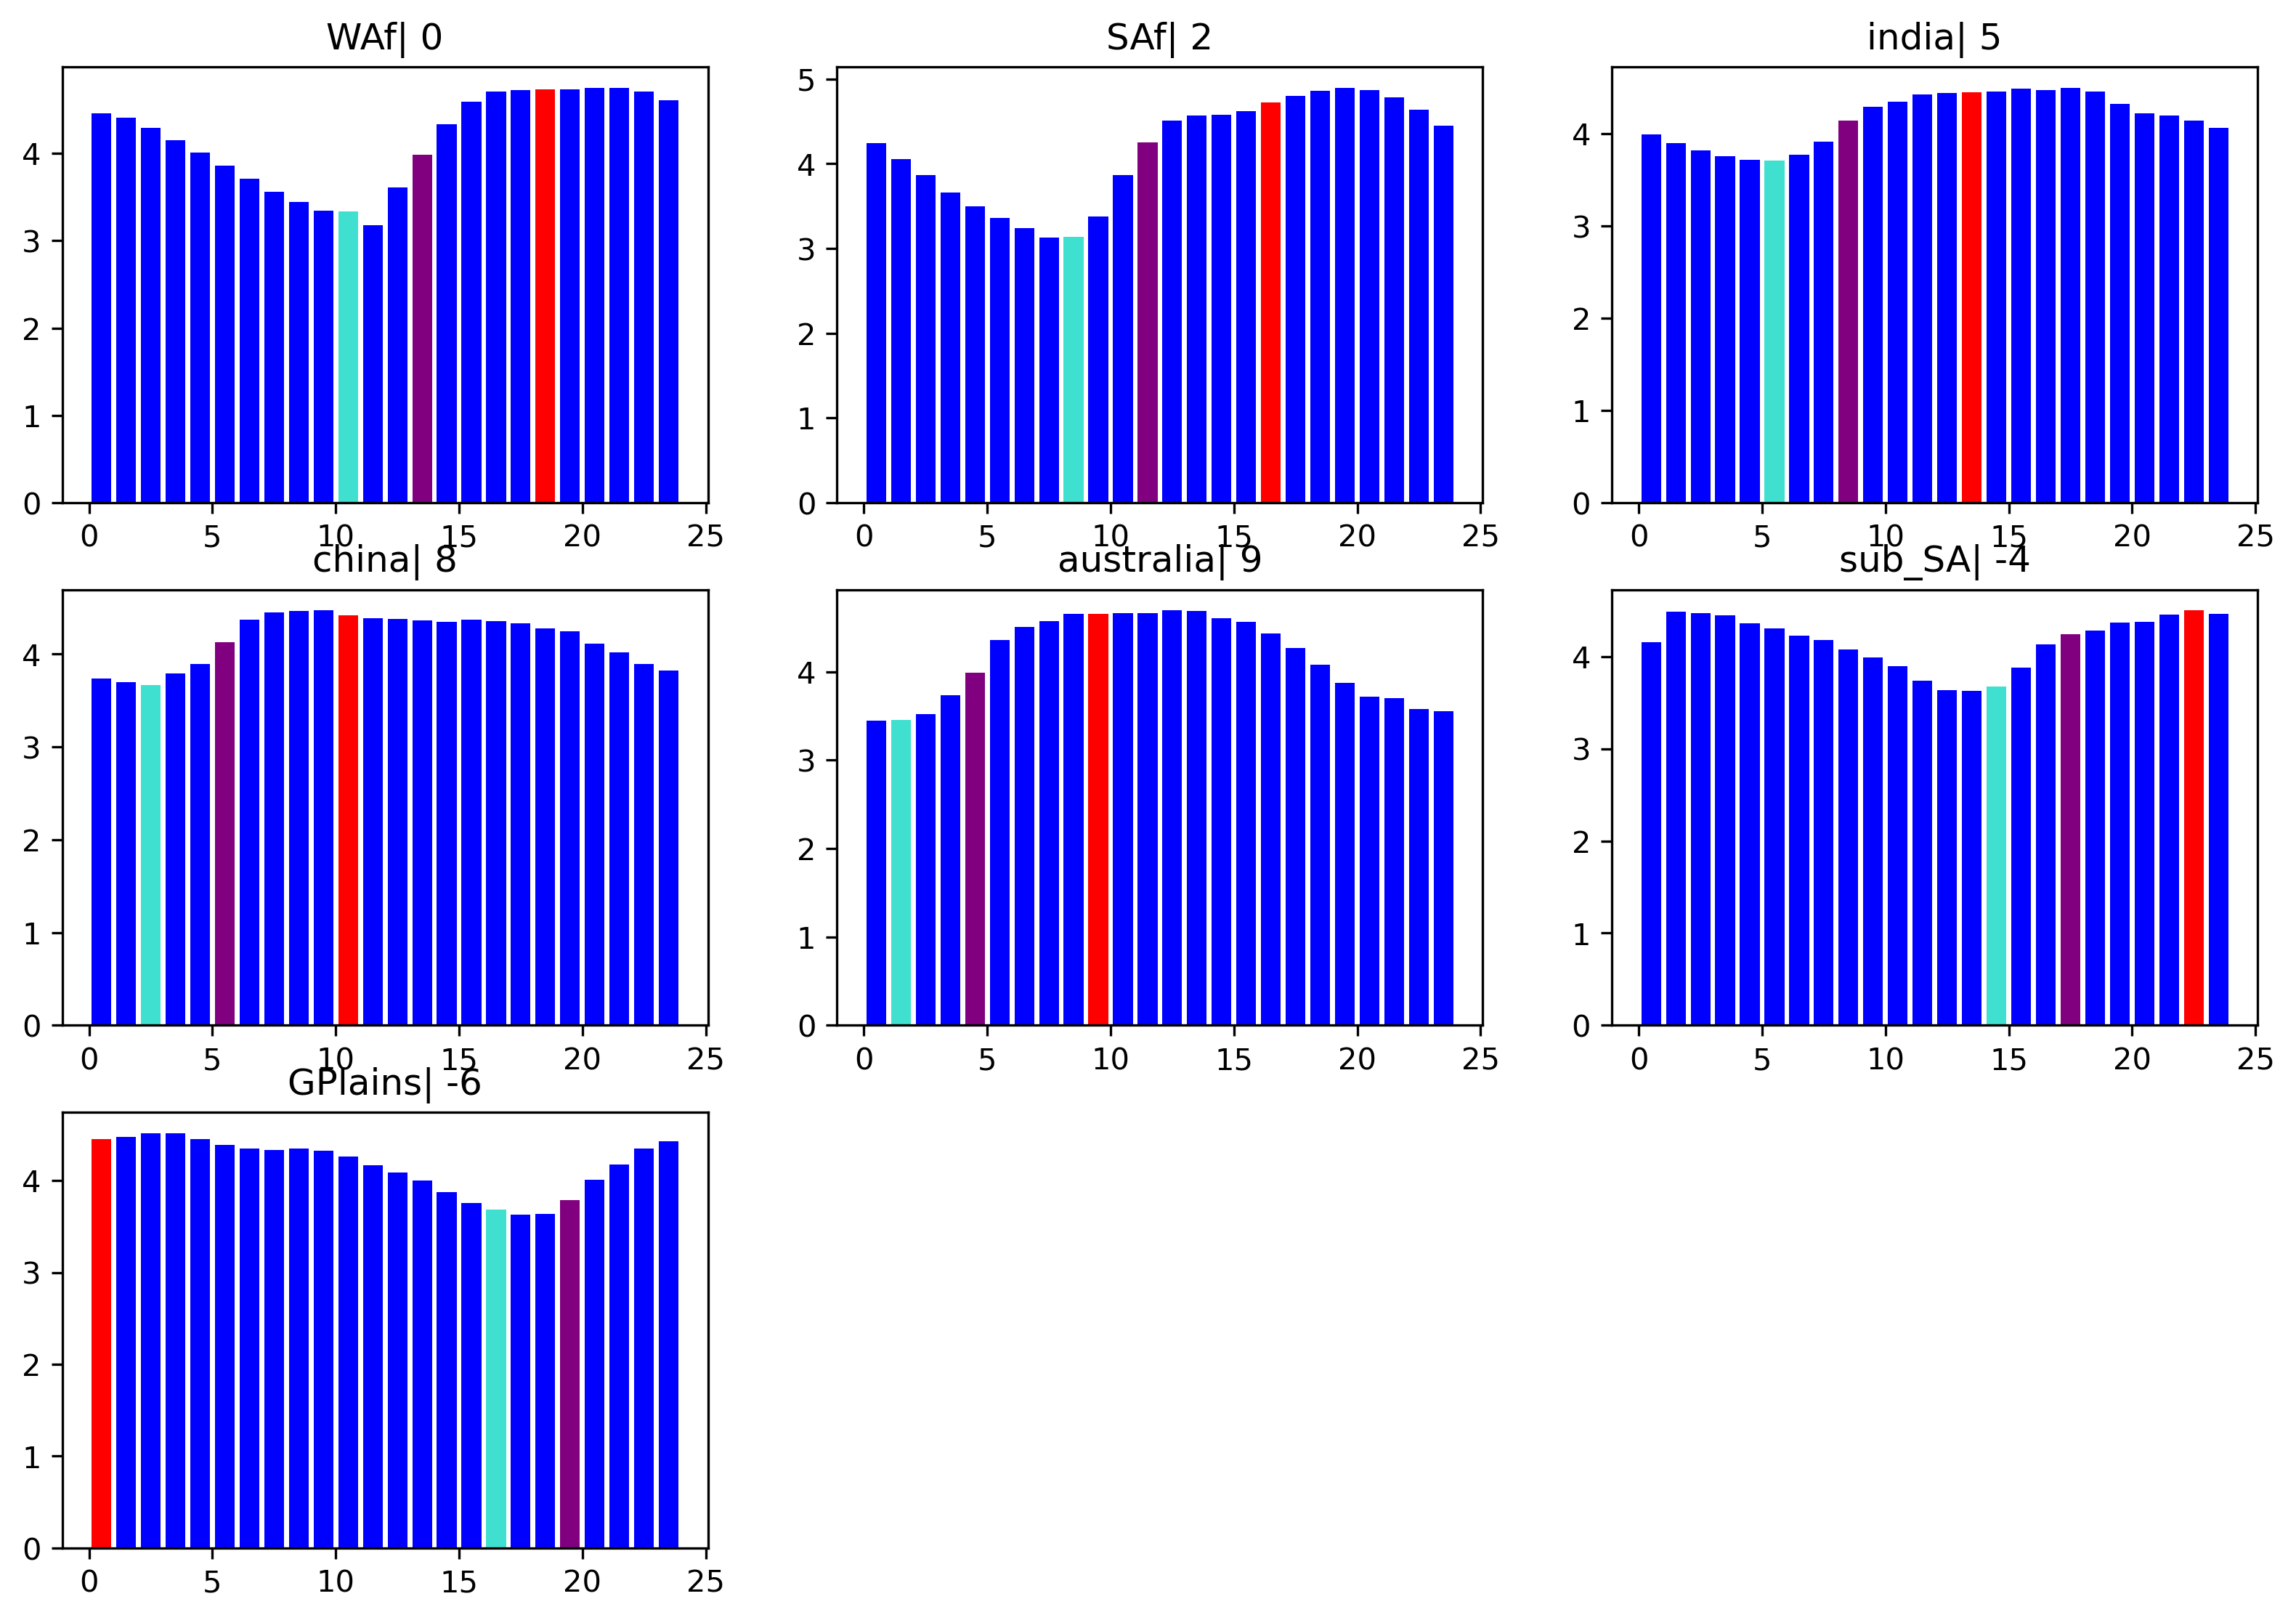

In [12]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['hour'], bins=np.arange(0,25))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
    ispos = int(np.where(mid_bin==18.5)[0])
    secpos = int(np.where(mid_bin==13.5)[0])
    firstpos = int(np.where(mid_bin==10.5)[0])
    #minpos = ispos-(MREGIONS[regs])[2]
    #ipdb.set_trace()
    minpos = ispos-(MREGIONS[regs])[2]
    miinpos = firstpos - (MREGIONS[regs])[2]
    miiinpos = secpos - (MREGIONS[regs])[2]
    print(minpos)
    if minpos == 24:
        minpos=0
    
    colors[minpos] = 'r'  # 1800
    colors[miinpos] = 'turquoise' # 1100
    colors[miiinpos] = 'purple' # 1400
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))


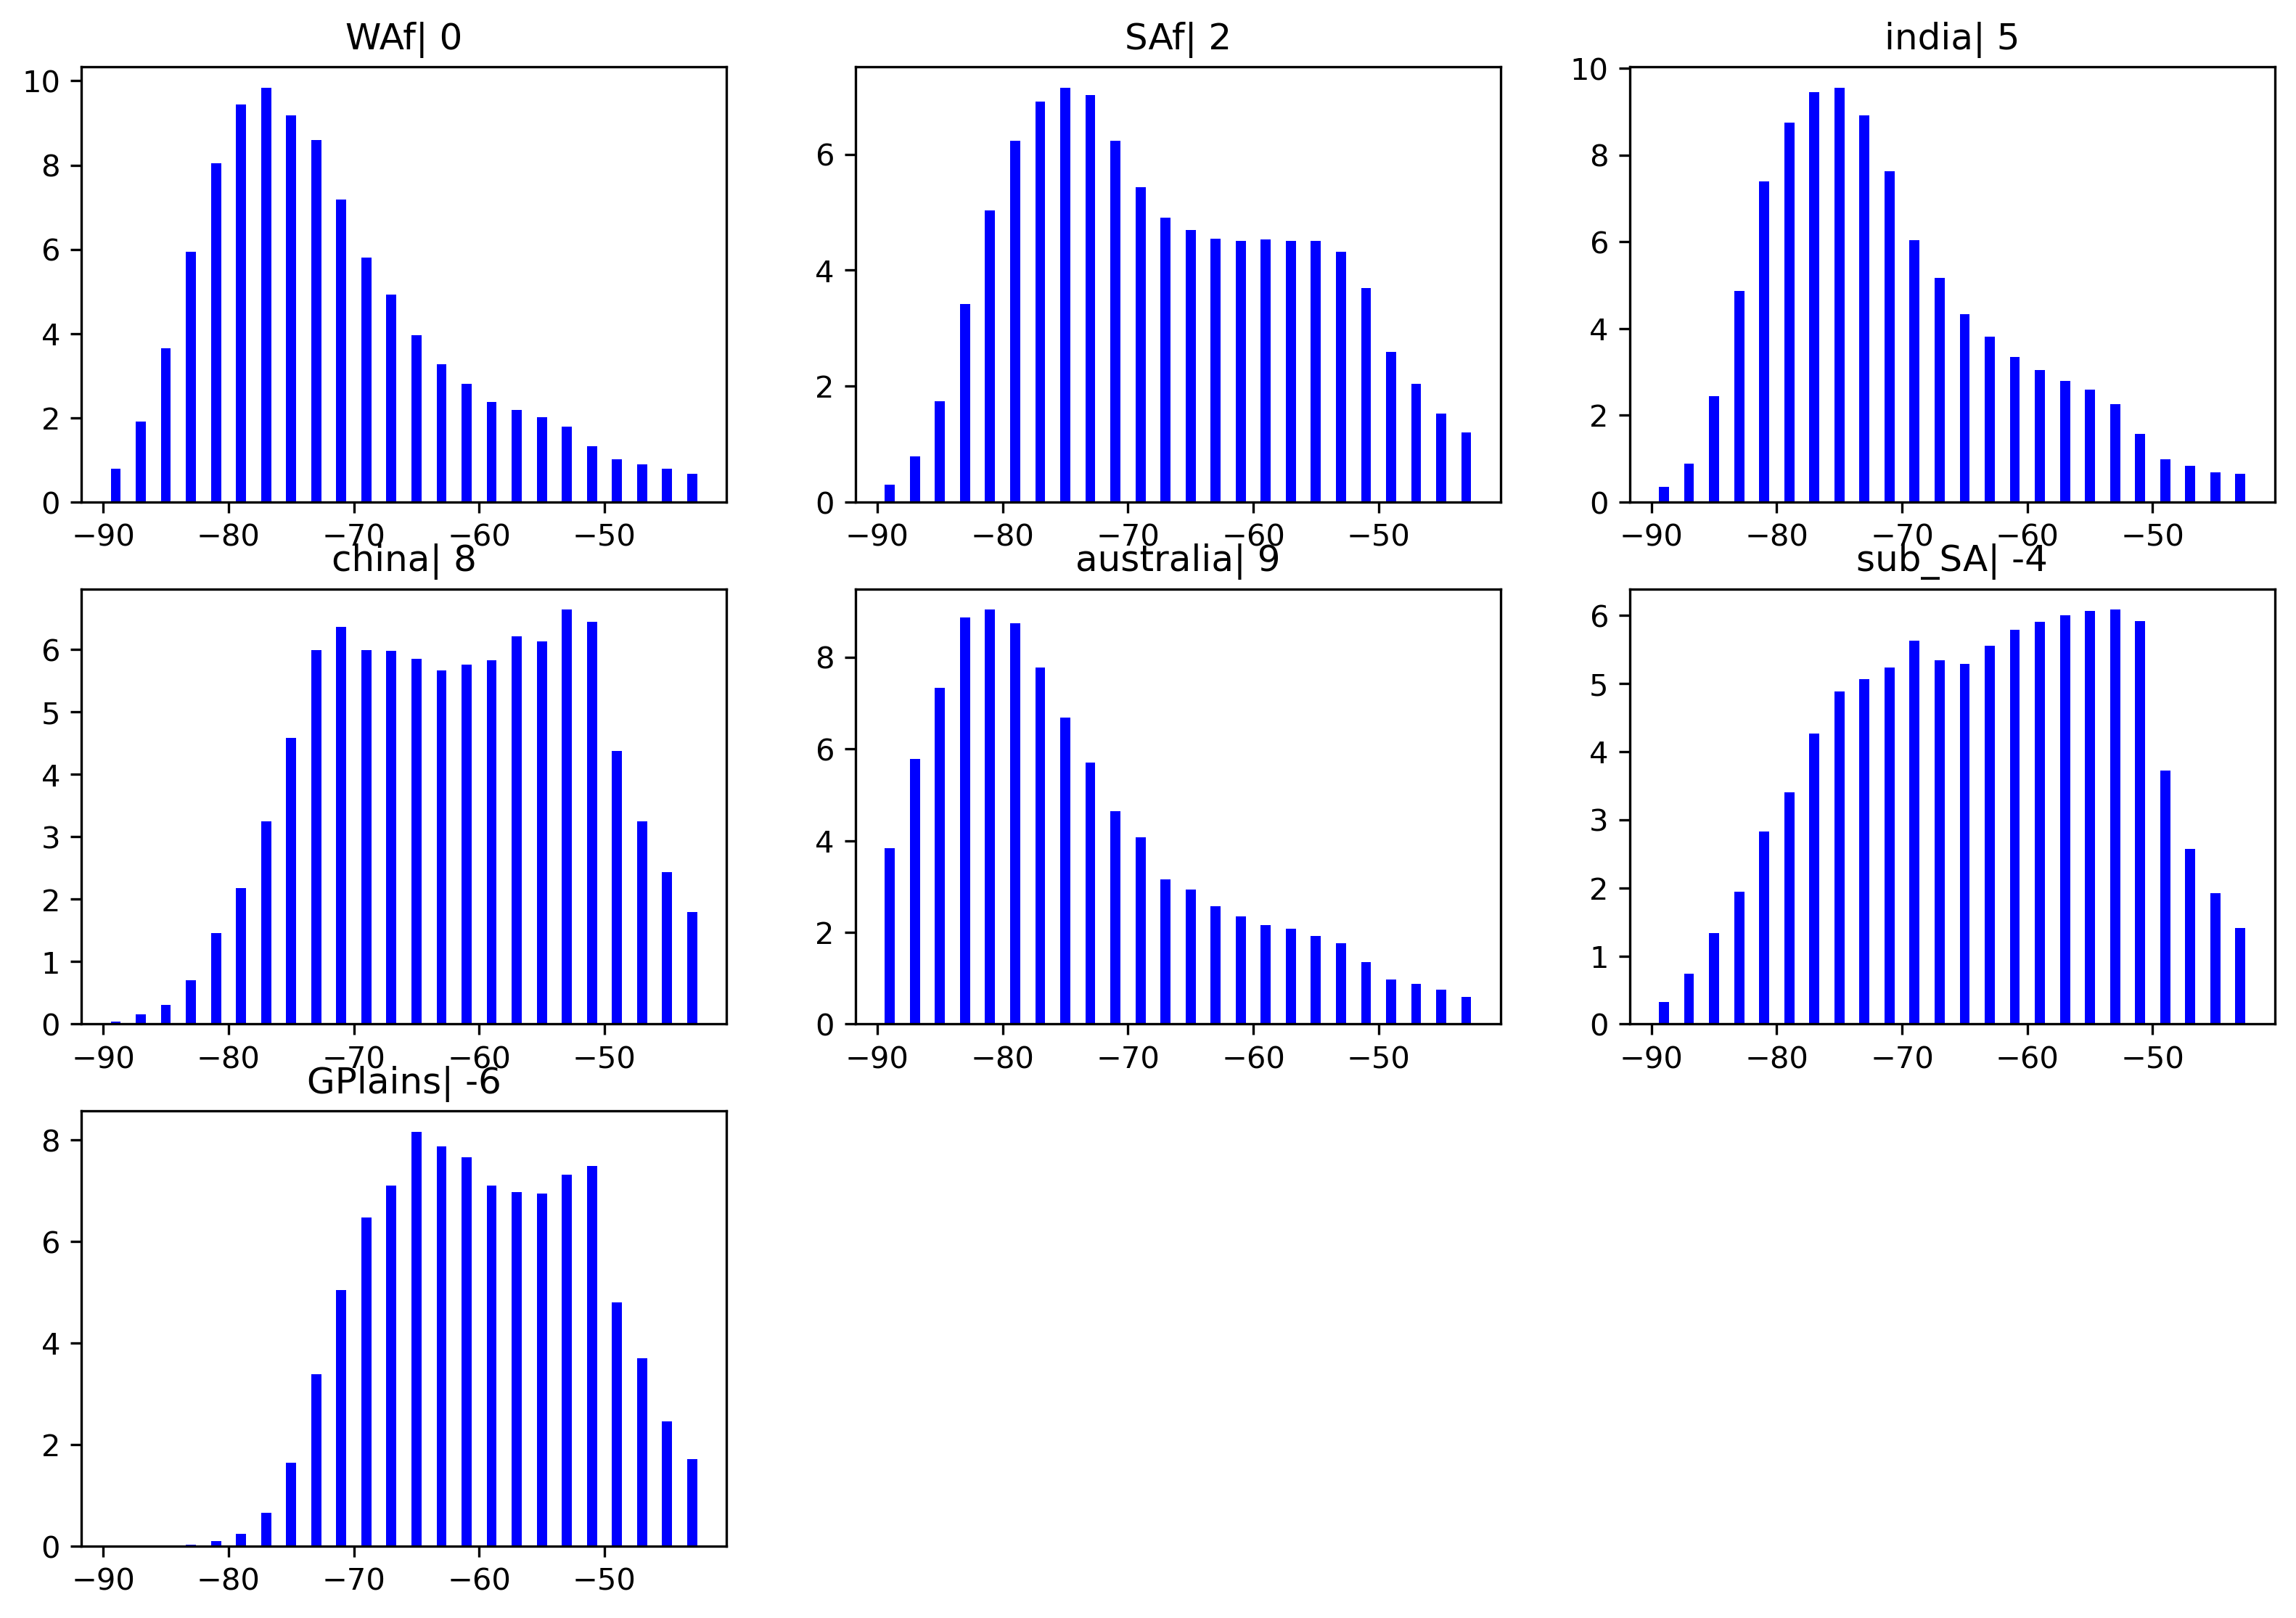

In [138]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['mintb']-273.15, bins=np.arange(-90,-40,2))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
#     ispos = int(np.where(mid_bin==18.5)[0])
#     secpos = int(np.where(mid_bin==13.5)[0])
#     firstpos = int(np.where(mid_bin==10.5)[0])
#     #minpos = ispos-(MREGIONS[regs])[2]
#     #ipdb.set_trace()
#     minpos = ispos-(MREGIONS[regs])[2]
#     miinpos = firstpos - (MREGIONS[regs])[2]
#     miiinpos = secpos - (MREGIONS[regs])[2]
#     print(minpos)
#     if minpos == 24:
#         minpos=0
    
#     colors[minpos] = 'r'
#     colors[miinpos] = 'turquoise'
#     colors[miiinpos] = 'purple'
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint_dist.jpg')

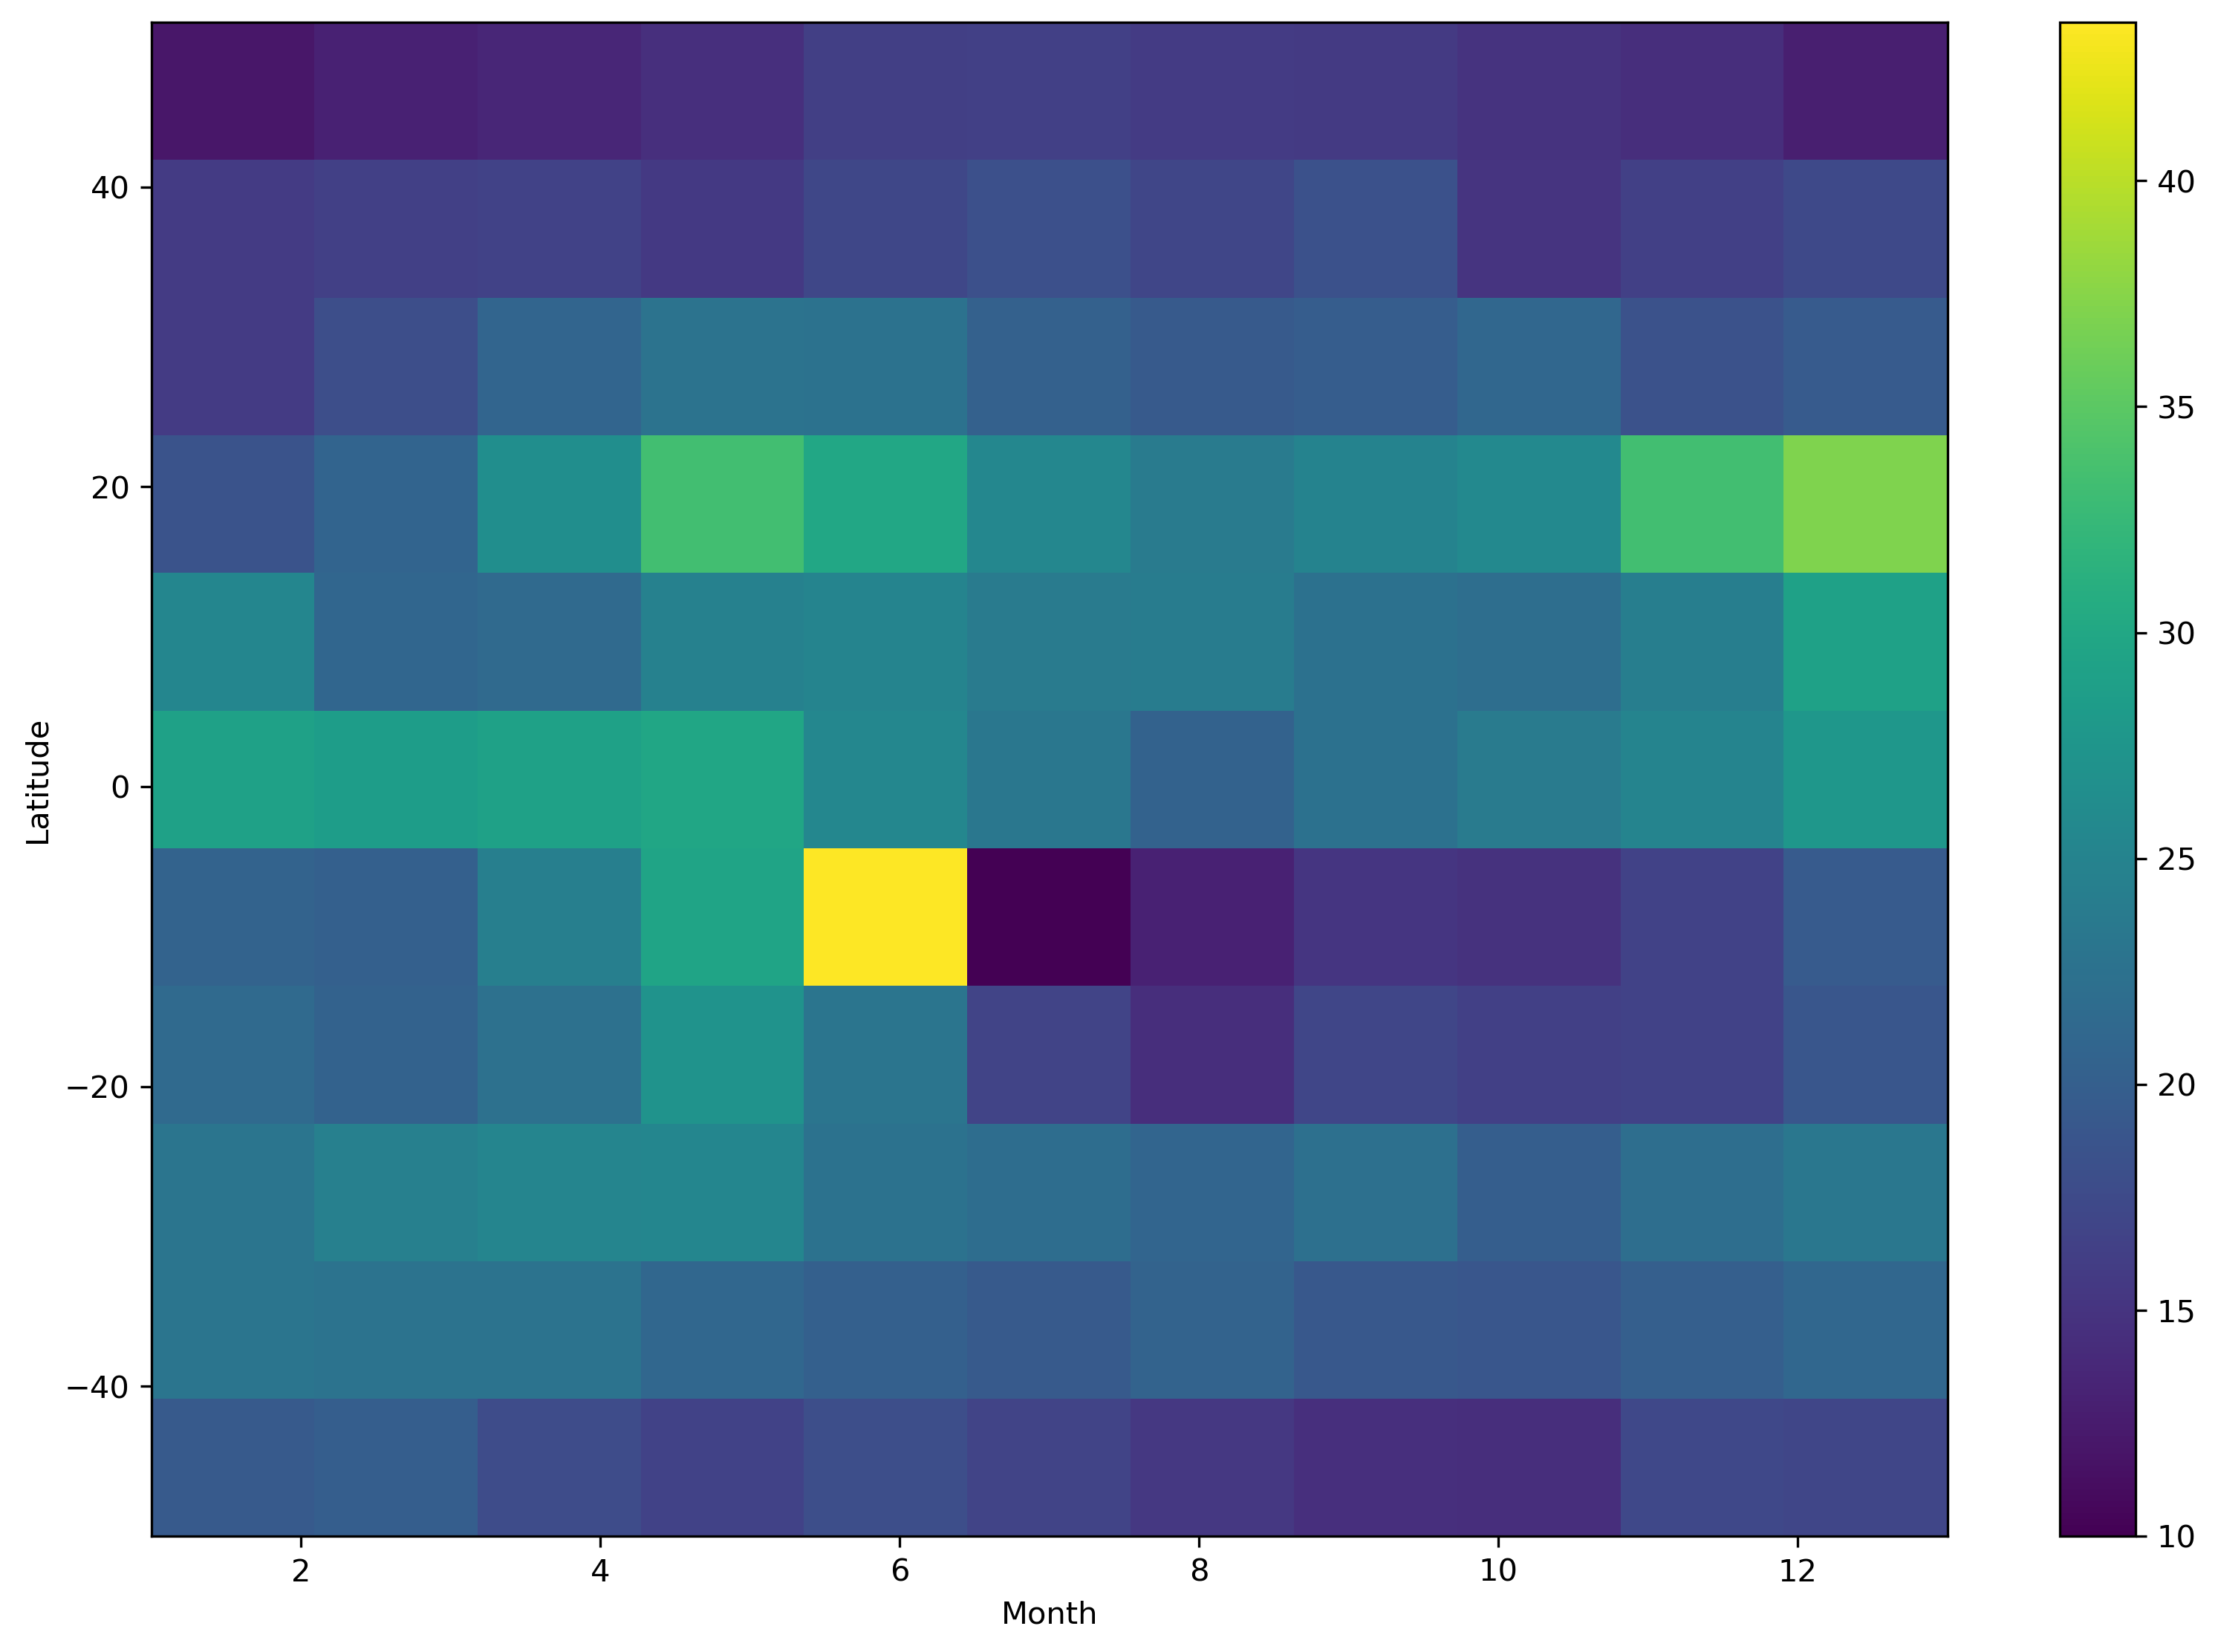

In [31]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []
for ids, regs in enumerate(MREGIONS.keys()):
    
    pick = rdics[regs]

    mon.extend(pick['month'])
    lat.extend(pick['meanlat'])
    dat.extend(pick['pf_maxrainrate1'])
    
    
tbin = np.linspace(-50,51,12)
sbin = np.linspace(1,13,12)

testbins = [sbin,tbin]
func1 = lambda y: np.nanmean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.nansum(np.isfinite(y))
func3 = lambda y: np.nansum(y>1)

ax = f.add_subplot(111)

ret = binned_statistic_2d(mon, lat, dat, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis', vmin=10) #vmax=p2-1, vmin=0.5  ##p2-1
plt.colorbar(mp)
plt.ylabel('Latitude')
plt.xlabel('Month')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):
    
#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')
f.savefig('/home/ck/Desktop/lmcs/latitude_mean_pf1MaxRainrate_heatmap_mixed.jpg')

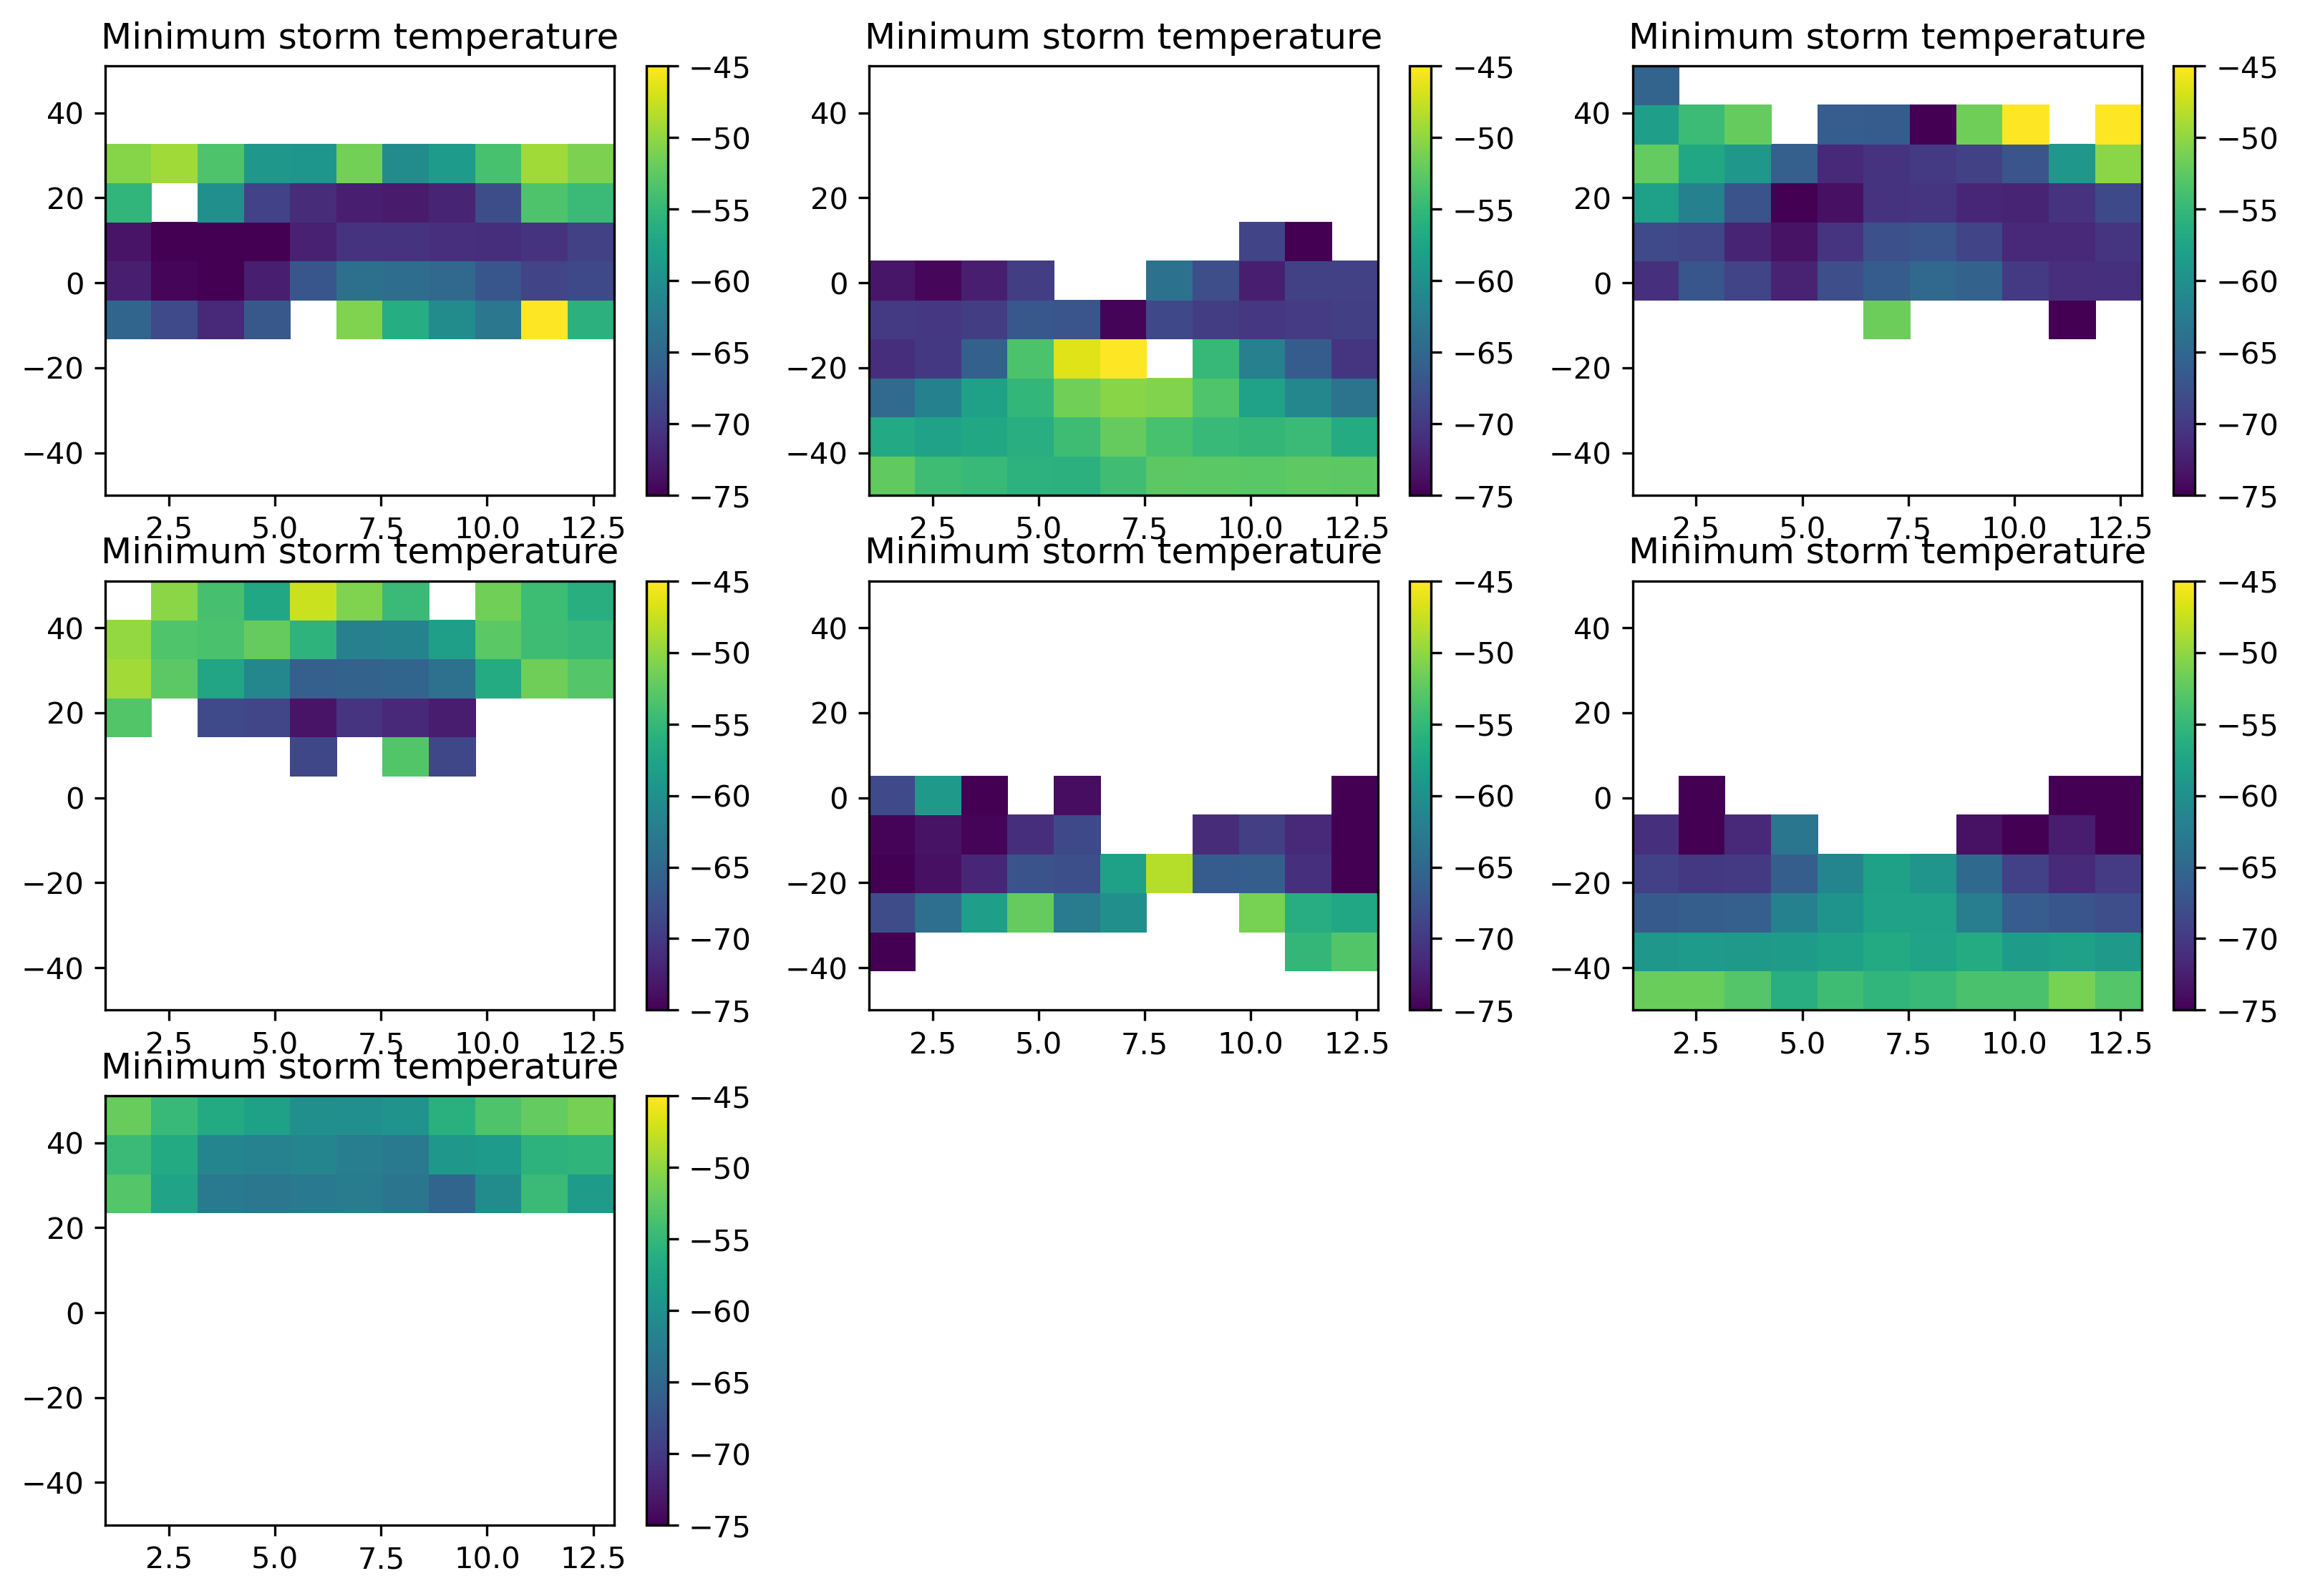

In [26]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    tbin = np.linspace(-50,51,12)
    sbin = np.linspace(1,13,12)

    testbins = [sbin,tbin]
    func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
    func2 = lambda y: np.sum(np.isfinite(y))
    func3 = lambda y: np.sum(y>1)

    xxu2 = pick['month']
    xxtc = pick['meanlat']
    xxch = pick['mintb']-273.15
    
    ret = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func1, bins=testbins)
    # count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
    # thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

    dd=ret.statistic.T

    mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis', vmin=-75, vmax=-45) #vmax=p2-1, vmin=0.5  ##p2-1
    plt.title(regs+' IQR ='+str(np.round(np.nanpercentile(xxch,75)-np.nanpercentile(xxch,25),2))+'K')
    plt.colorbar(mp)
    plt.title('Minimum storm temperature')
f.savefig('/home/ck/Desktop/lmcs/latitude_mean_minT_heatmap_regions.jpg')

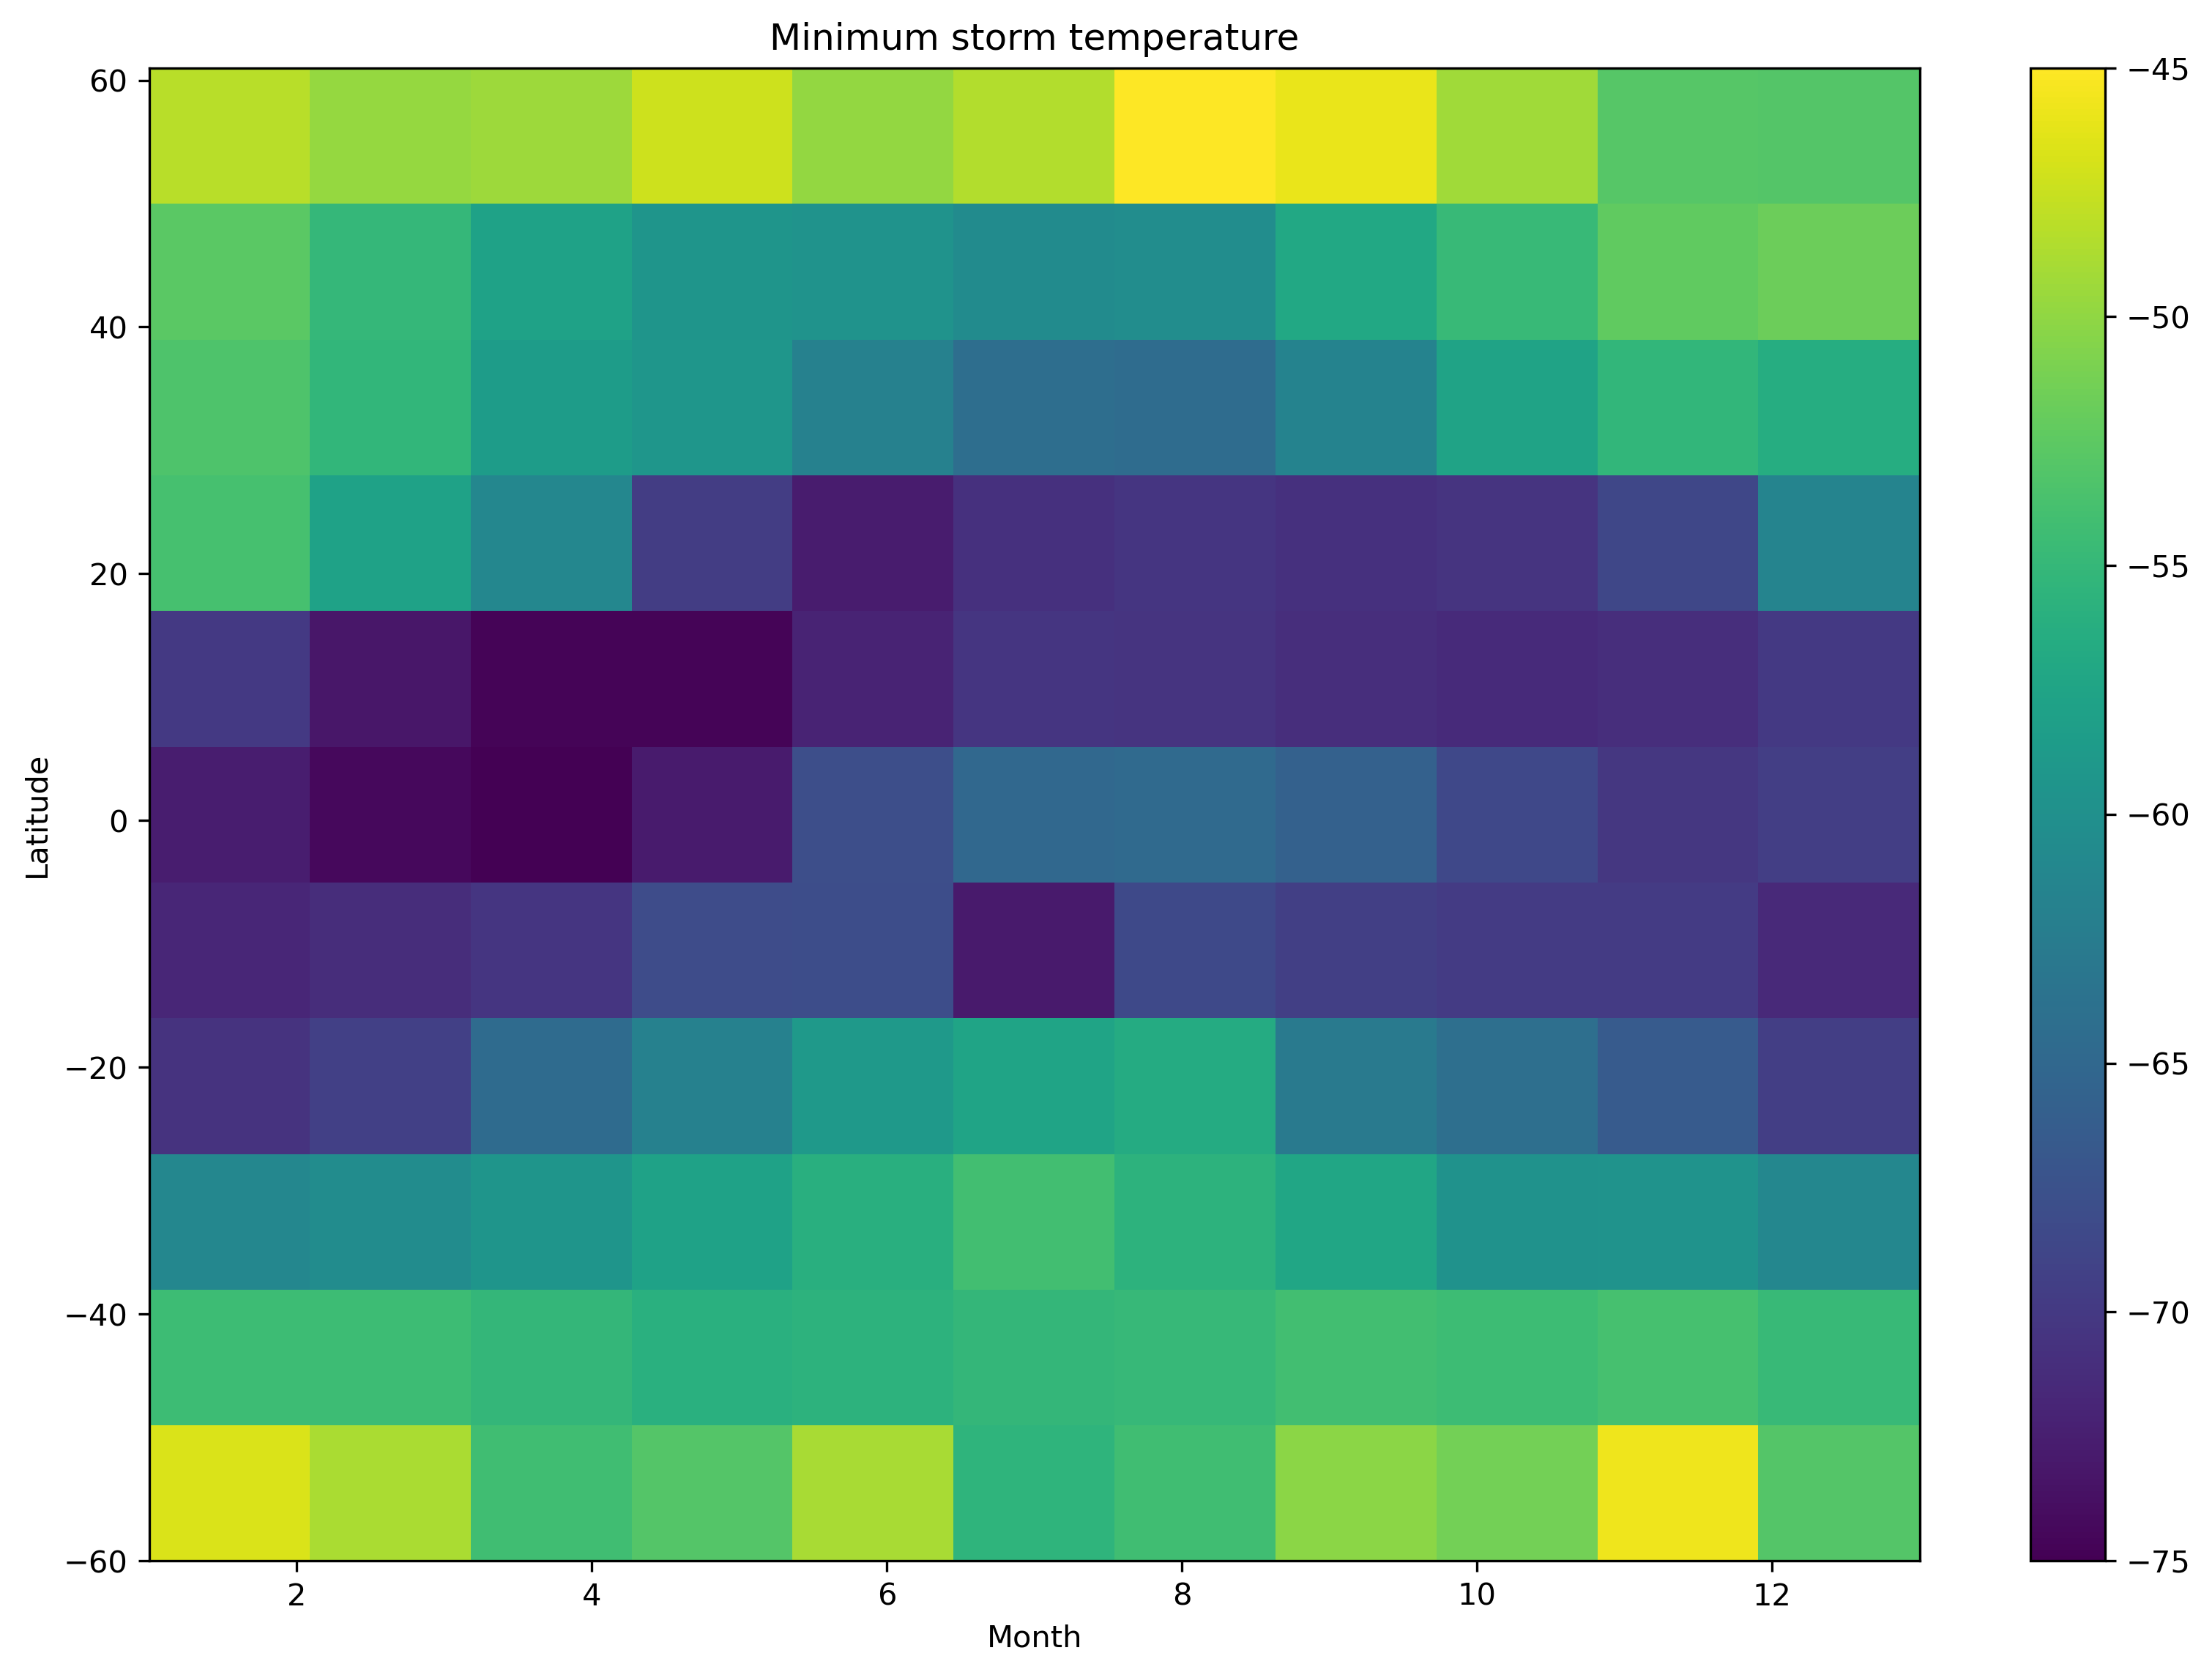

In [25]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []
for ids, regs in enumerate(MREGIONS.keys()):
    
    pick = rdics[regs]

    mon.extend(pick['month'])
    lat.extend(pick['meanlat'])
    dat.extend(pick['mintb']-273.15)
    
    
tbin = np.linspace(-60,61,12)
sbin = np.linspace(1,13,12)

testbins = [sbin,tbin]
func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>1)

ax = f.add_subplot(111)

ret = binned_statistic_2d(mon, lat, dat, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis', vmin=-75, vmax=-45) #vmax=p2-1, vmin=0.5  ##p2-1
plt.colorbar(mp)
plt.ylabel('Latitude')
plt.xlabel('Month')
plt.title('Minimum storm temperature')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):
    
#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')
f.savefig('/home/ck/Desktop/lmcs/latitude_mean_minT_heatmap_mixed.jpg')

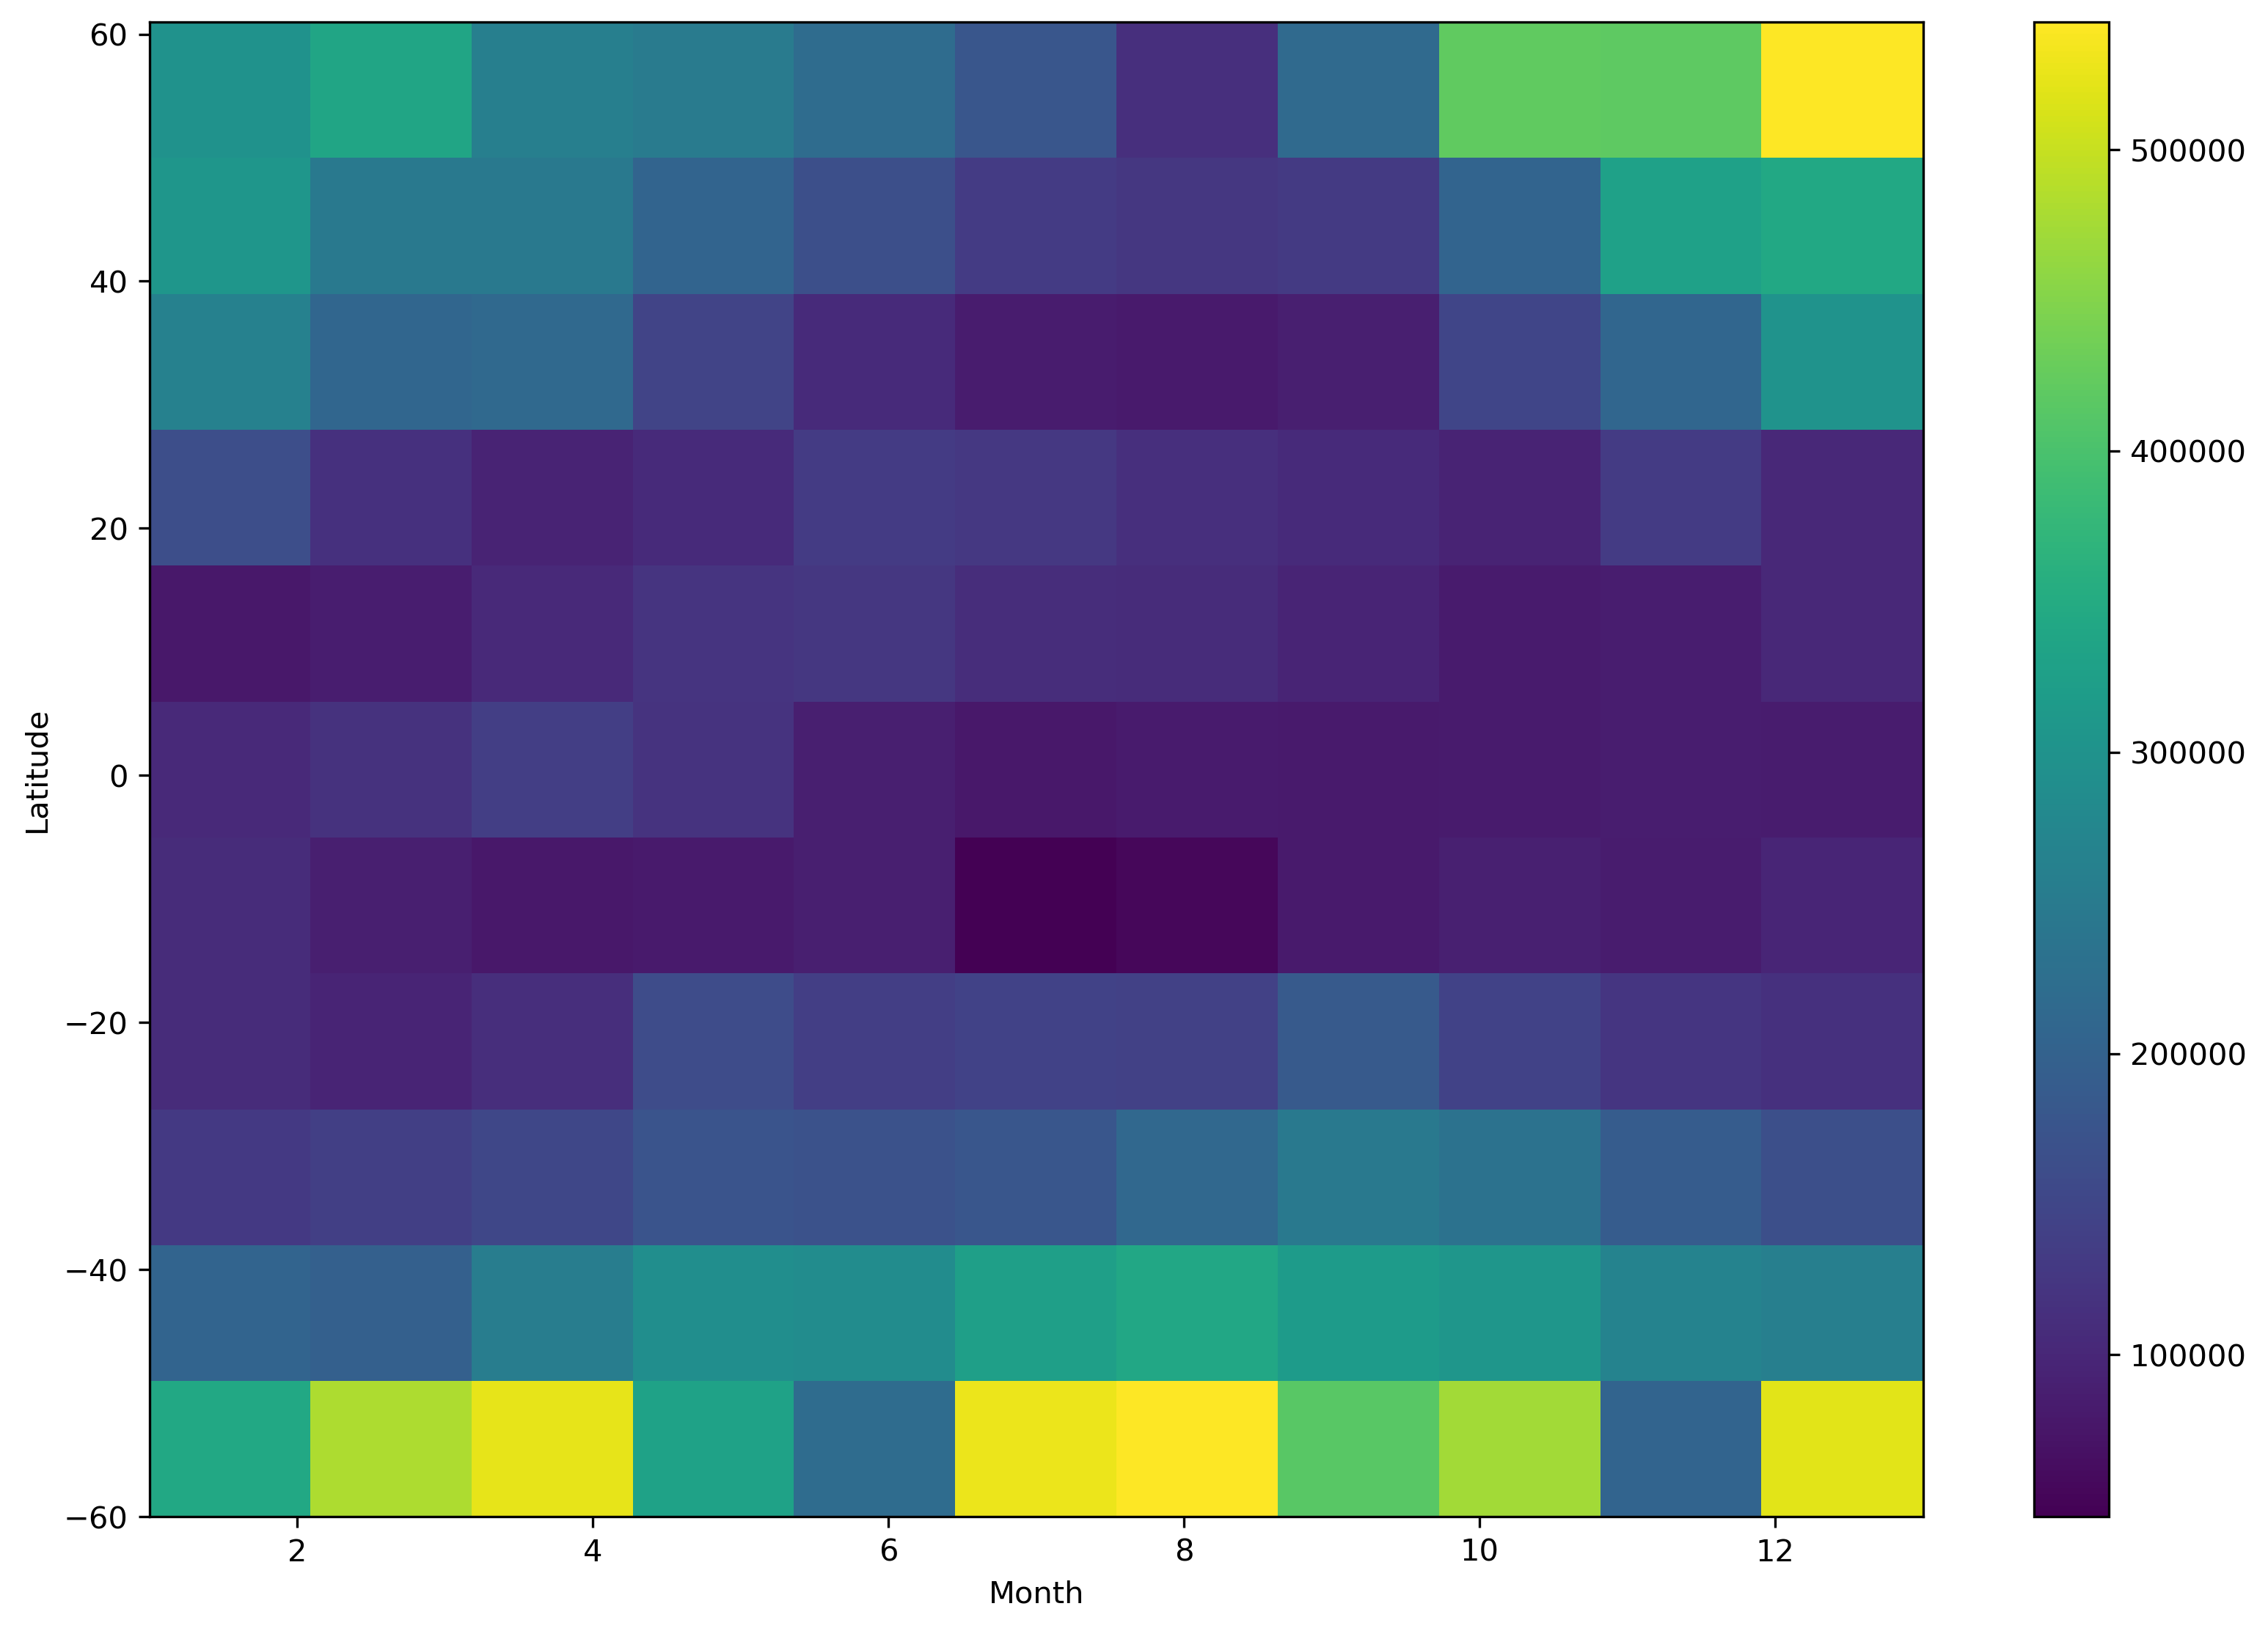

In [22]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []
for ids, regs in enumerate(MREGIONS.keys()):
    
    pick = rdics[regs]

    mon.extend(pick['month'])
    lat.extend(pick['meanlat'])
    dat.extend(pick['ccs_area'])
    
    
tbin = np.linspace(-60,61,12)
sbin = np.linspace(1,13,12)

testbins = [sbin,tbin]
func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>1)

ax = f.add_subplot(111)

ret = binned_statistic_2d(mon, lat, dat, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis') #vmax=p2-1, vmin=0.5  ##p2-1
plt.colorbar(mp)
plt.ylabel('Latitude')
plt.xlabel('Month')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):
    
#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')
f.savefig('/home/ck/Desktop/lmcs/latitude_mean_minT_heatmap_ccsArea.jpg')

Text(0.5, 0, 'Month')

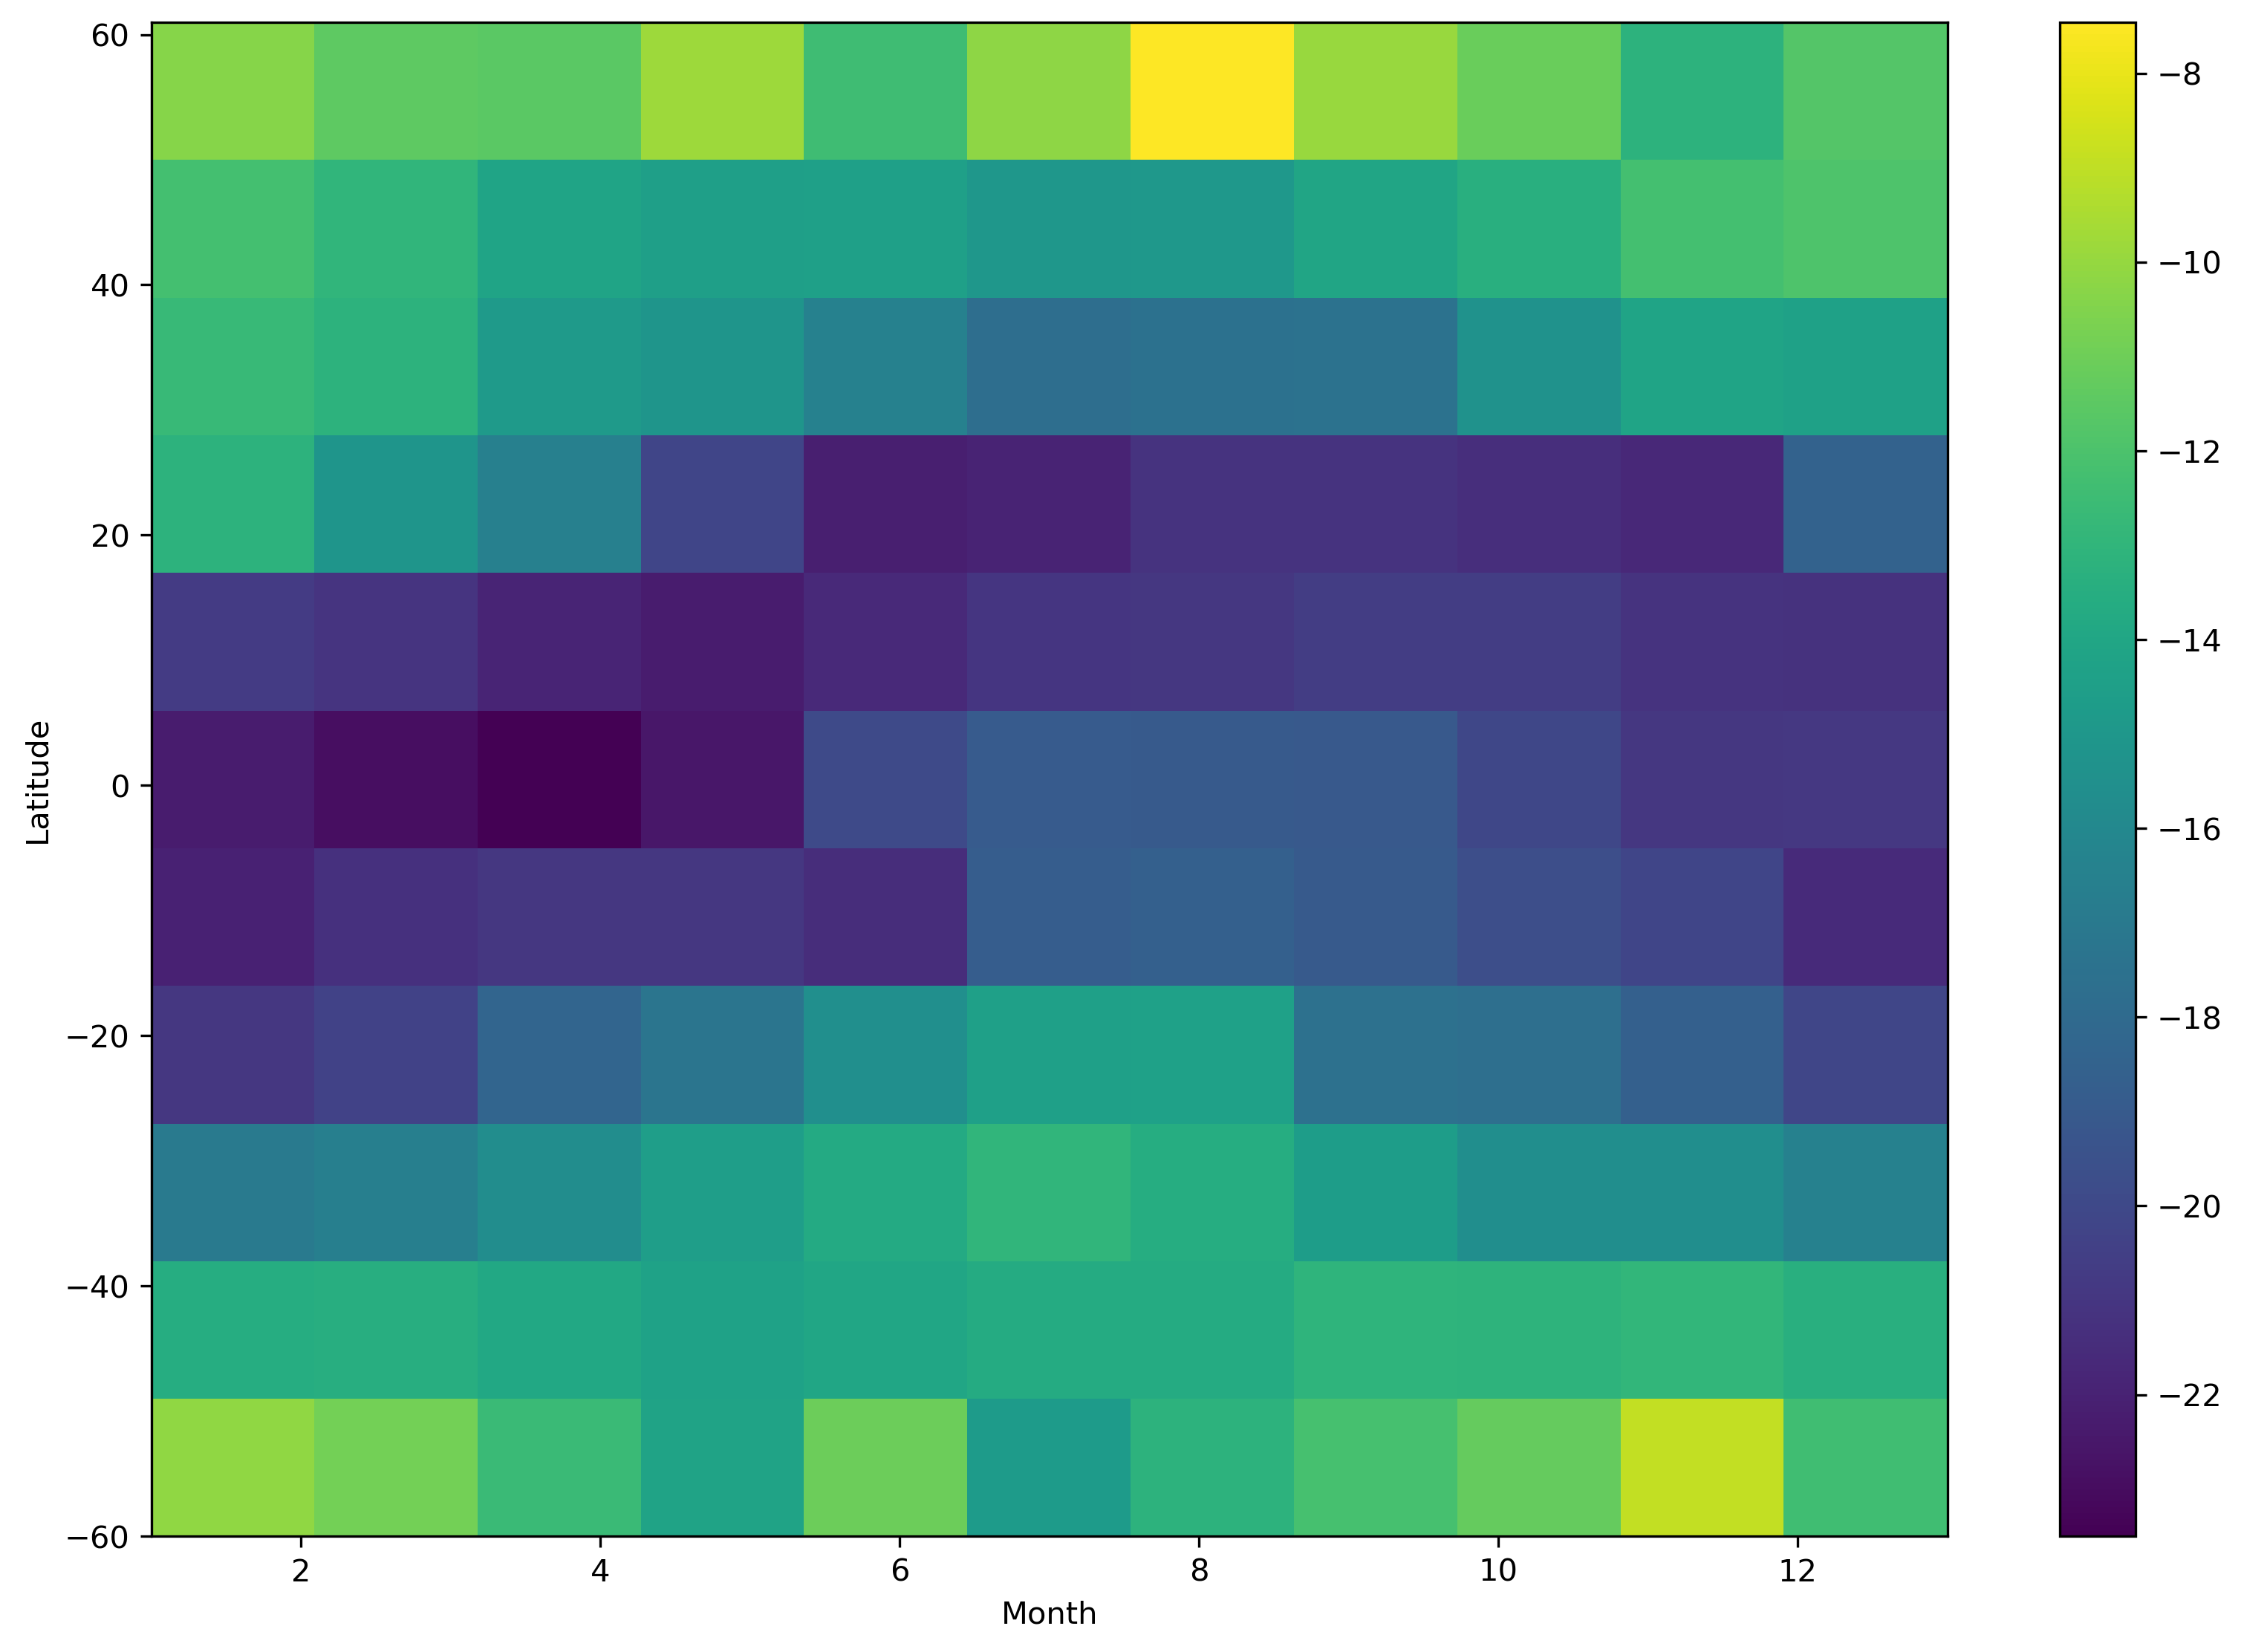

In [126]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []
for ids, regs in enumerate(MREGIONS.keys()):
    
    pick = rdics[regs]

    mon.extend(pick['month'])
    lat.extend(pick['meanlat'])
    dat.extend(pick['mintb']-pick['meantb'])
    
    
tbin = np.linspace(-60,61,12)
sbin = np.linspace(1,13,12)

testbins = [sbin,tbin]
func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>1)

ax = f.add_subplot(111)

ret = binned_statistic_2d(mon, lat, dat, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis') #vmax=p2-1, vmin=0.5  ##p2-1
plt.colorbar(mp)
plt.ylabel('Latitude')
plt.xlabel('Month')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):
    
#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')

Text(0.5, 0, 'Month')

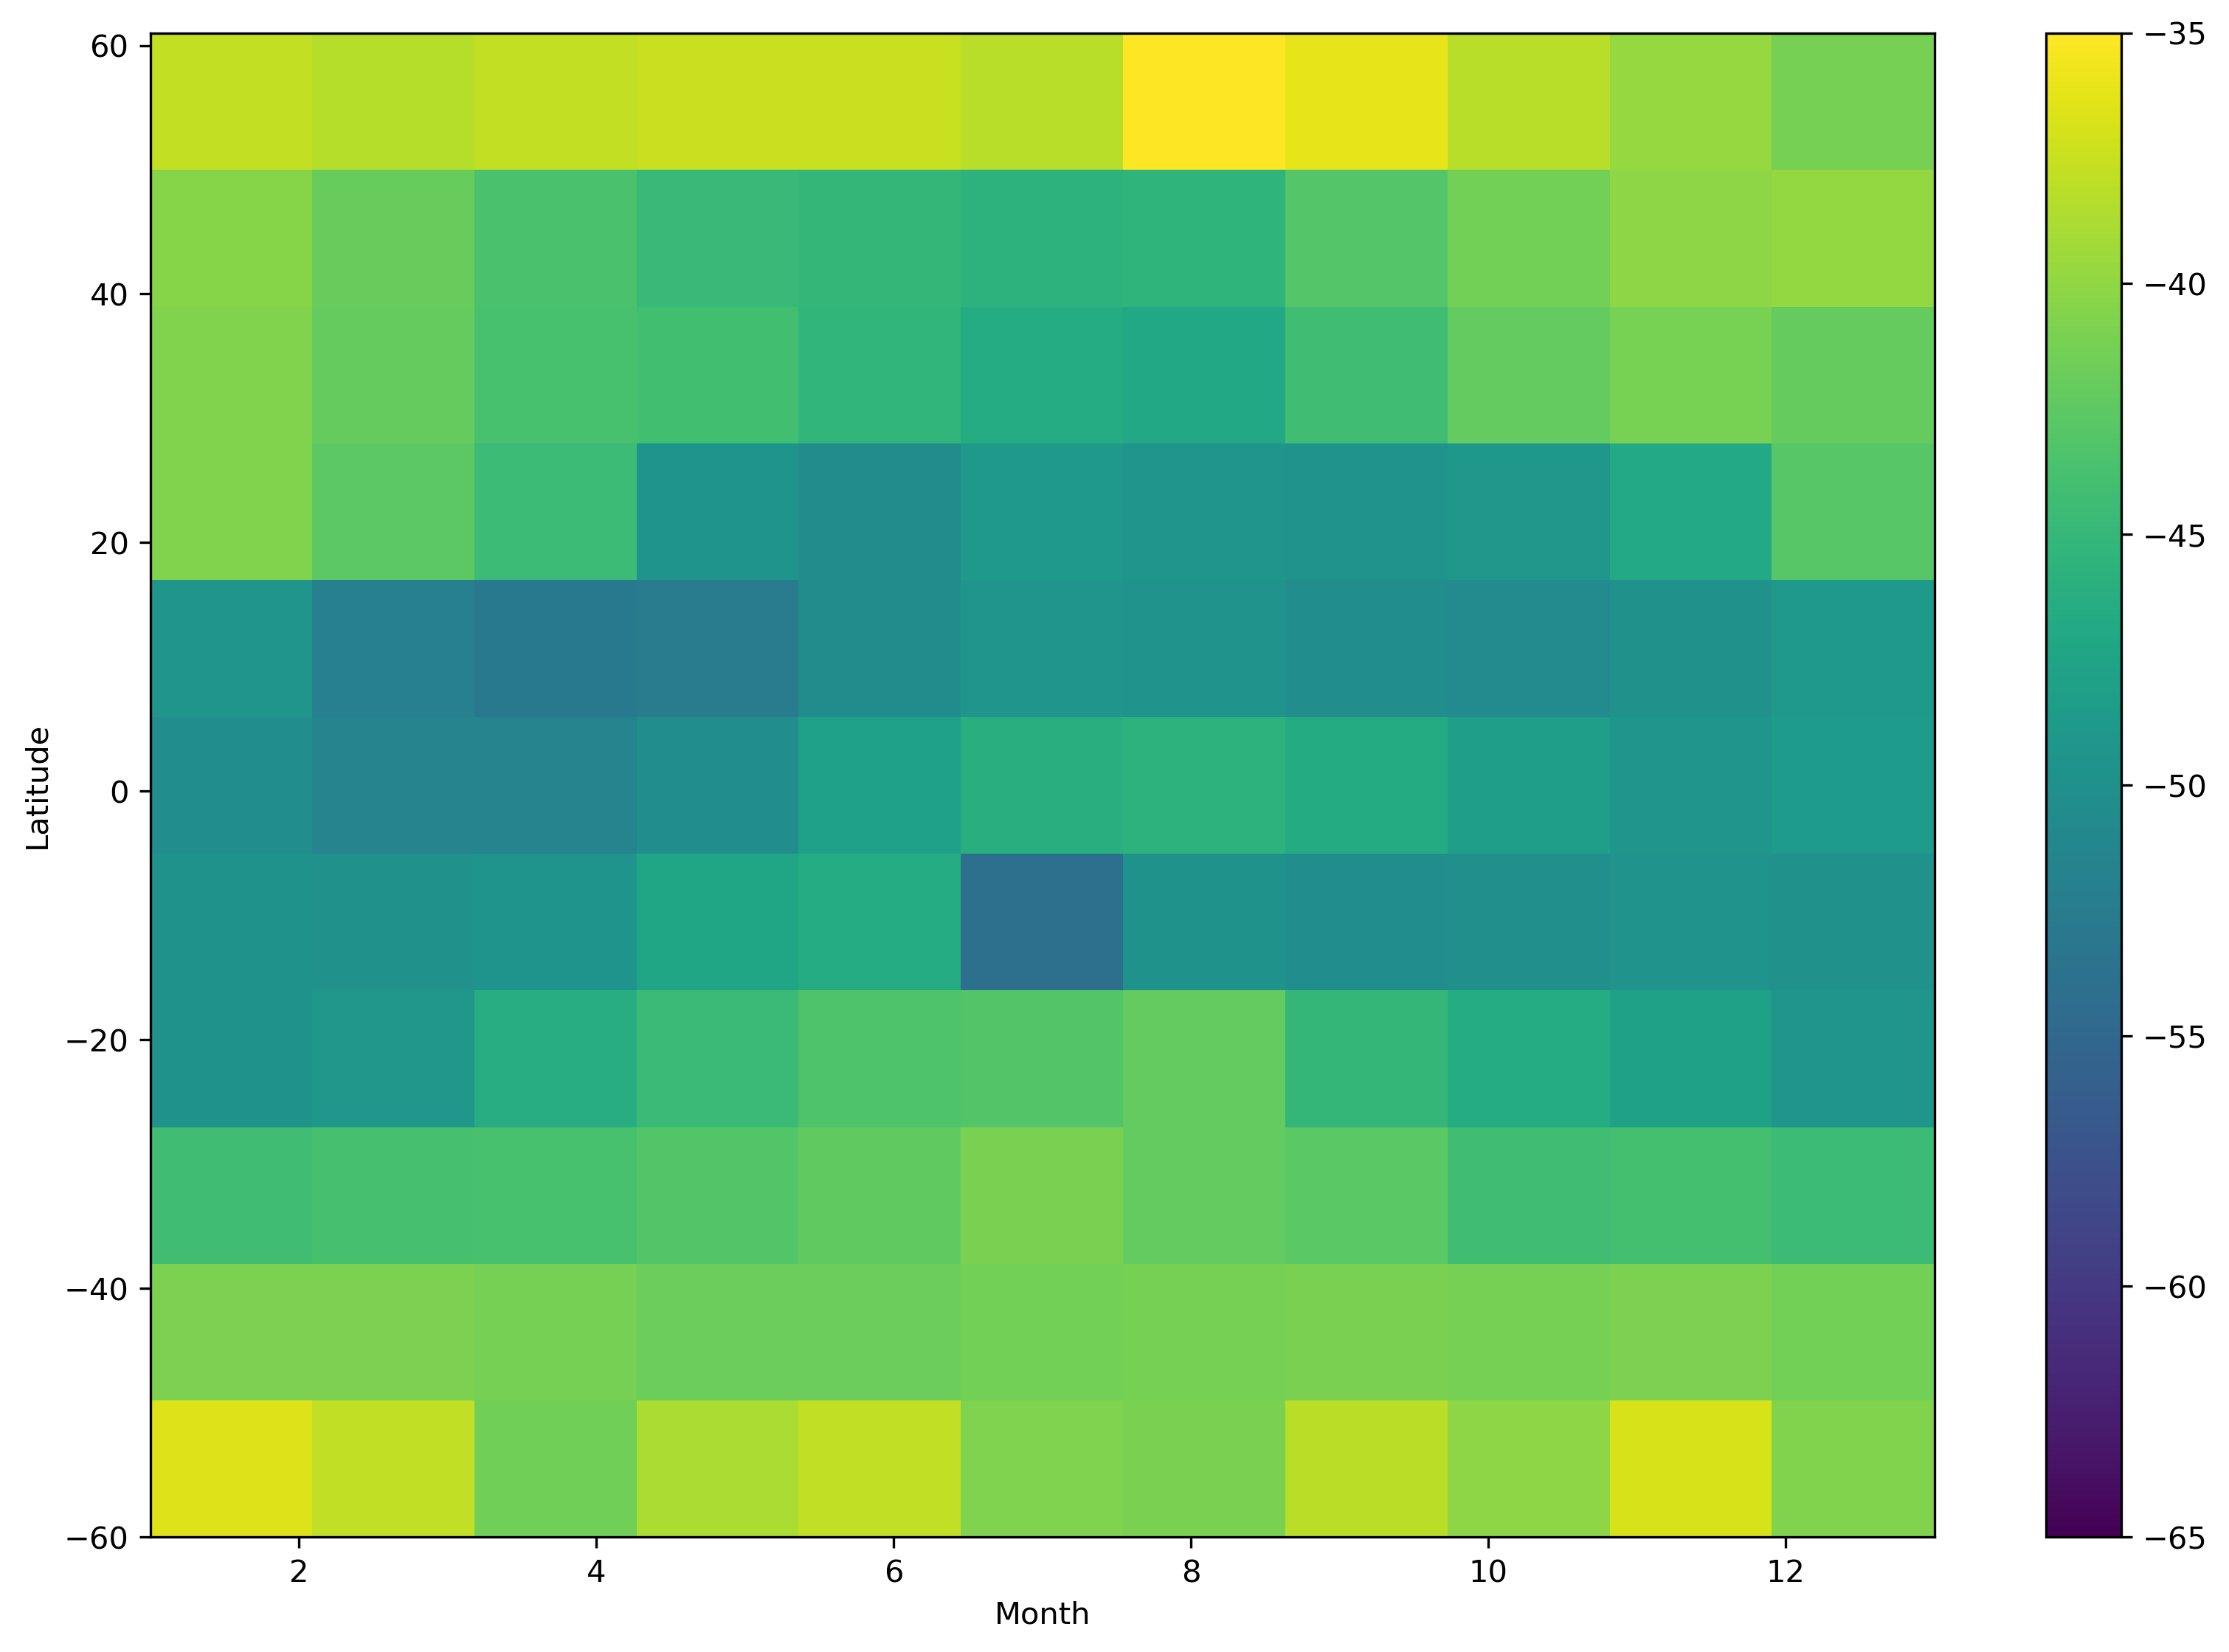

In [121]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []
for ids, regs in enumerate(MREGIONS.keys()):
    
    pick = rdics[regs]

    mon.extend(pick['month'])
    lat.extend(pick['meanlat'])
    dat.extend(pick['meantb']-273.15)
    
    
tbin = np.linspace(-60,61,12)
sbin = np.linspace(1,13,12)

testbins = [sbin,tbin]
func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>1)

ax = f.add_subplot(111)

ret = binned_statistic_2d(mon, lat, dat, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis', vmin=-65, vmax=-35) #vmax=p2-1, vmin=0.5  ##p2-1
plt.colorbar(mp)
plt.ylabel('Latitude')
plt.xlabel('Month')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):
    
#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')

In [23]:
import windrose 
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.projections import register_projection

register_projection(WindroseAxes)
color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']

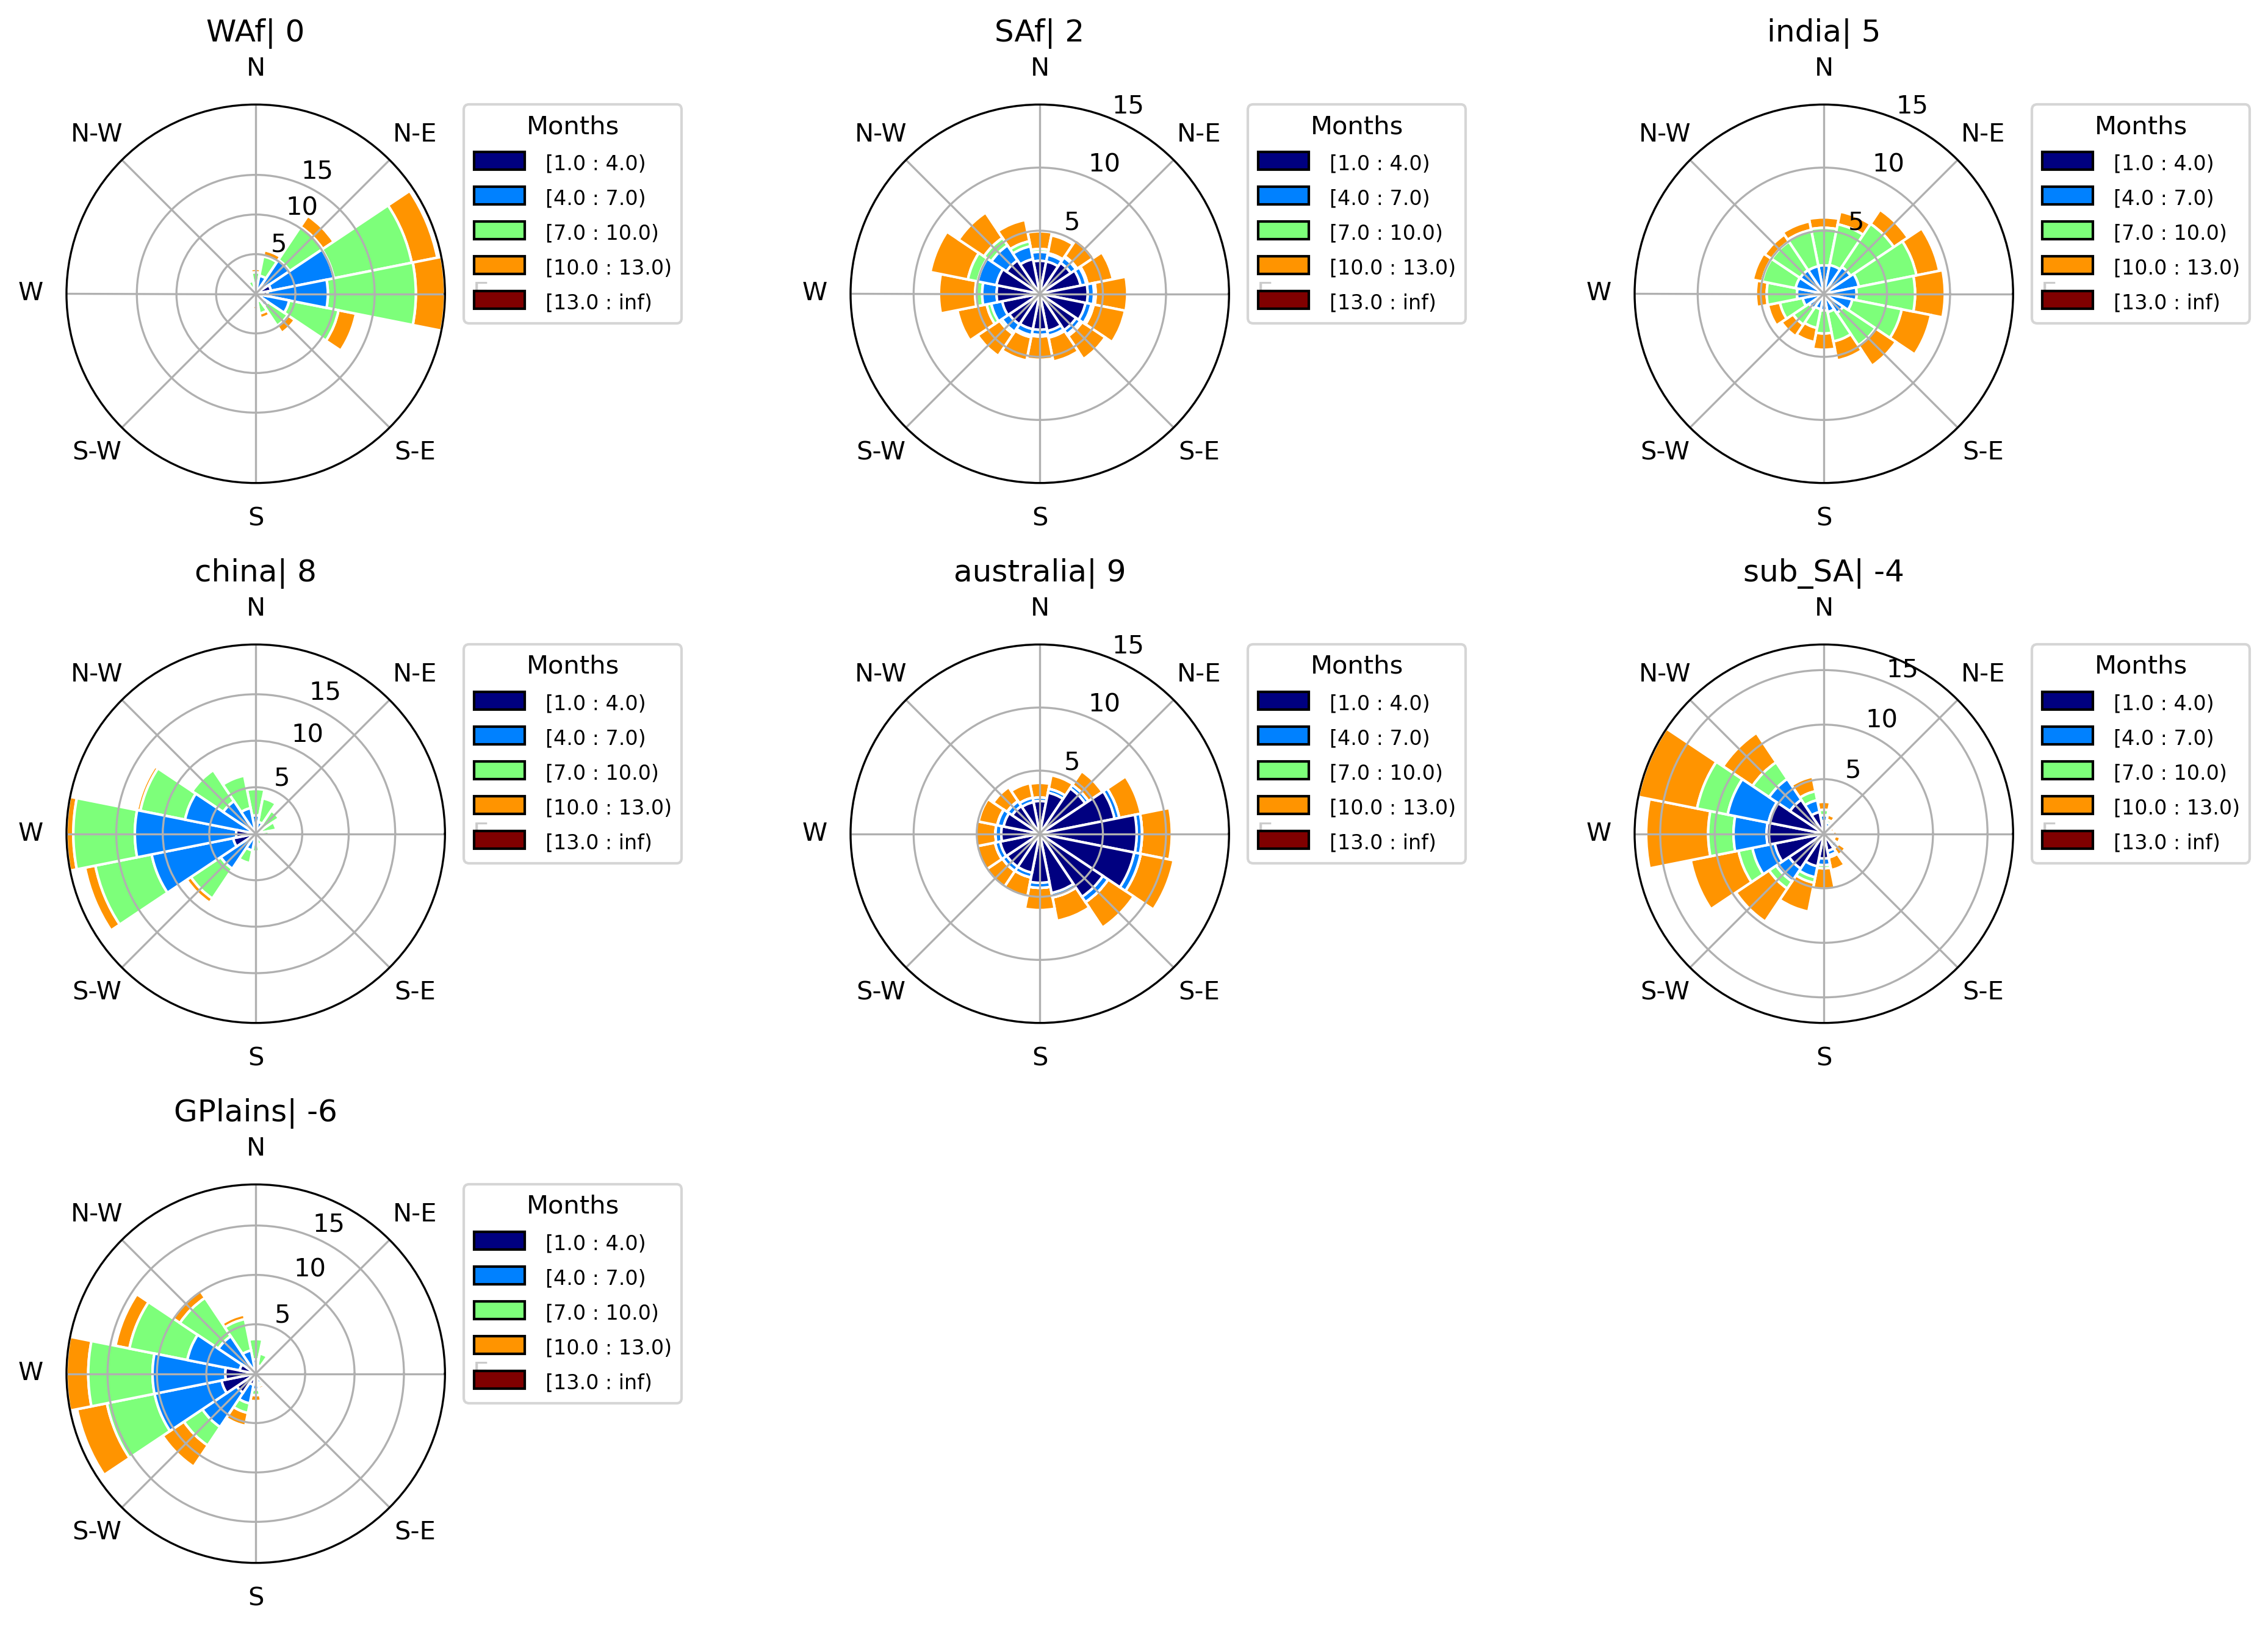

In [24]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1,  projection='windrose')
    
    pick = rdics[regs]

    umean = np.sin(np.deg2rad(pick['direction-1'])) + np.sin(np.deg2rad(pick['direction1'])) +  np.sin(np.deg2rad(pick['direction0'])) +  np.sin(np.deg2rad(pick['direction-2']))
    vmean = np.cos(np.deg2rad(pick['direction-1'])) + np.cos(np.deg2rad(pick['direction1'])) +  np.cos(np.deg2rad(pick['direction0'])) +  np.cos(np.deg2rad(pick['direction-2']))

    avg_wd = np.rad2deg(np.arctan2(umean, vmean))
    
    posi = np.where(avg_wd<0)
    #ipdb.set_trace()
    avg_wd  = avg_wd.values
    avg_wd[posi[0]] = avg_wd[posi[0]] + 360

    # print('mean WD', avg_wd, fi['d60irection'])
    direct = avg_wd -180
    direct[direct<0] = direct[direct<0] +360
    
   # direct = pick['direction0']0
    
    #####################
    ws_array2 = pick['month']  #np.array(wsin.flatten())
    wd_array2 = direct

    ax = WindroseAxes.from_ax(ax)
    ax.bar(wd_array2, ws_array2, normed=True, opening=1.0, edgecolor='white', bins=[1,4,7,10,13])
    ax.set_yticks(np.arange(5, 20, step=5))
    ax.set_yticklabels(np.arange(5, 20, step=5))



    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
    ax.set_legend(title = 'Months', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint_dist.jpg')

plt.tight_layout()
f.savefig('/home/ck/Desktop/lmcs/storm_direction_windrose.jpg')

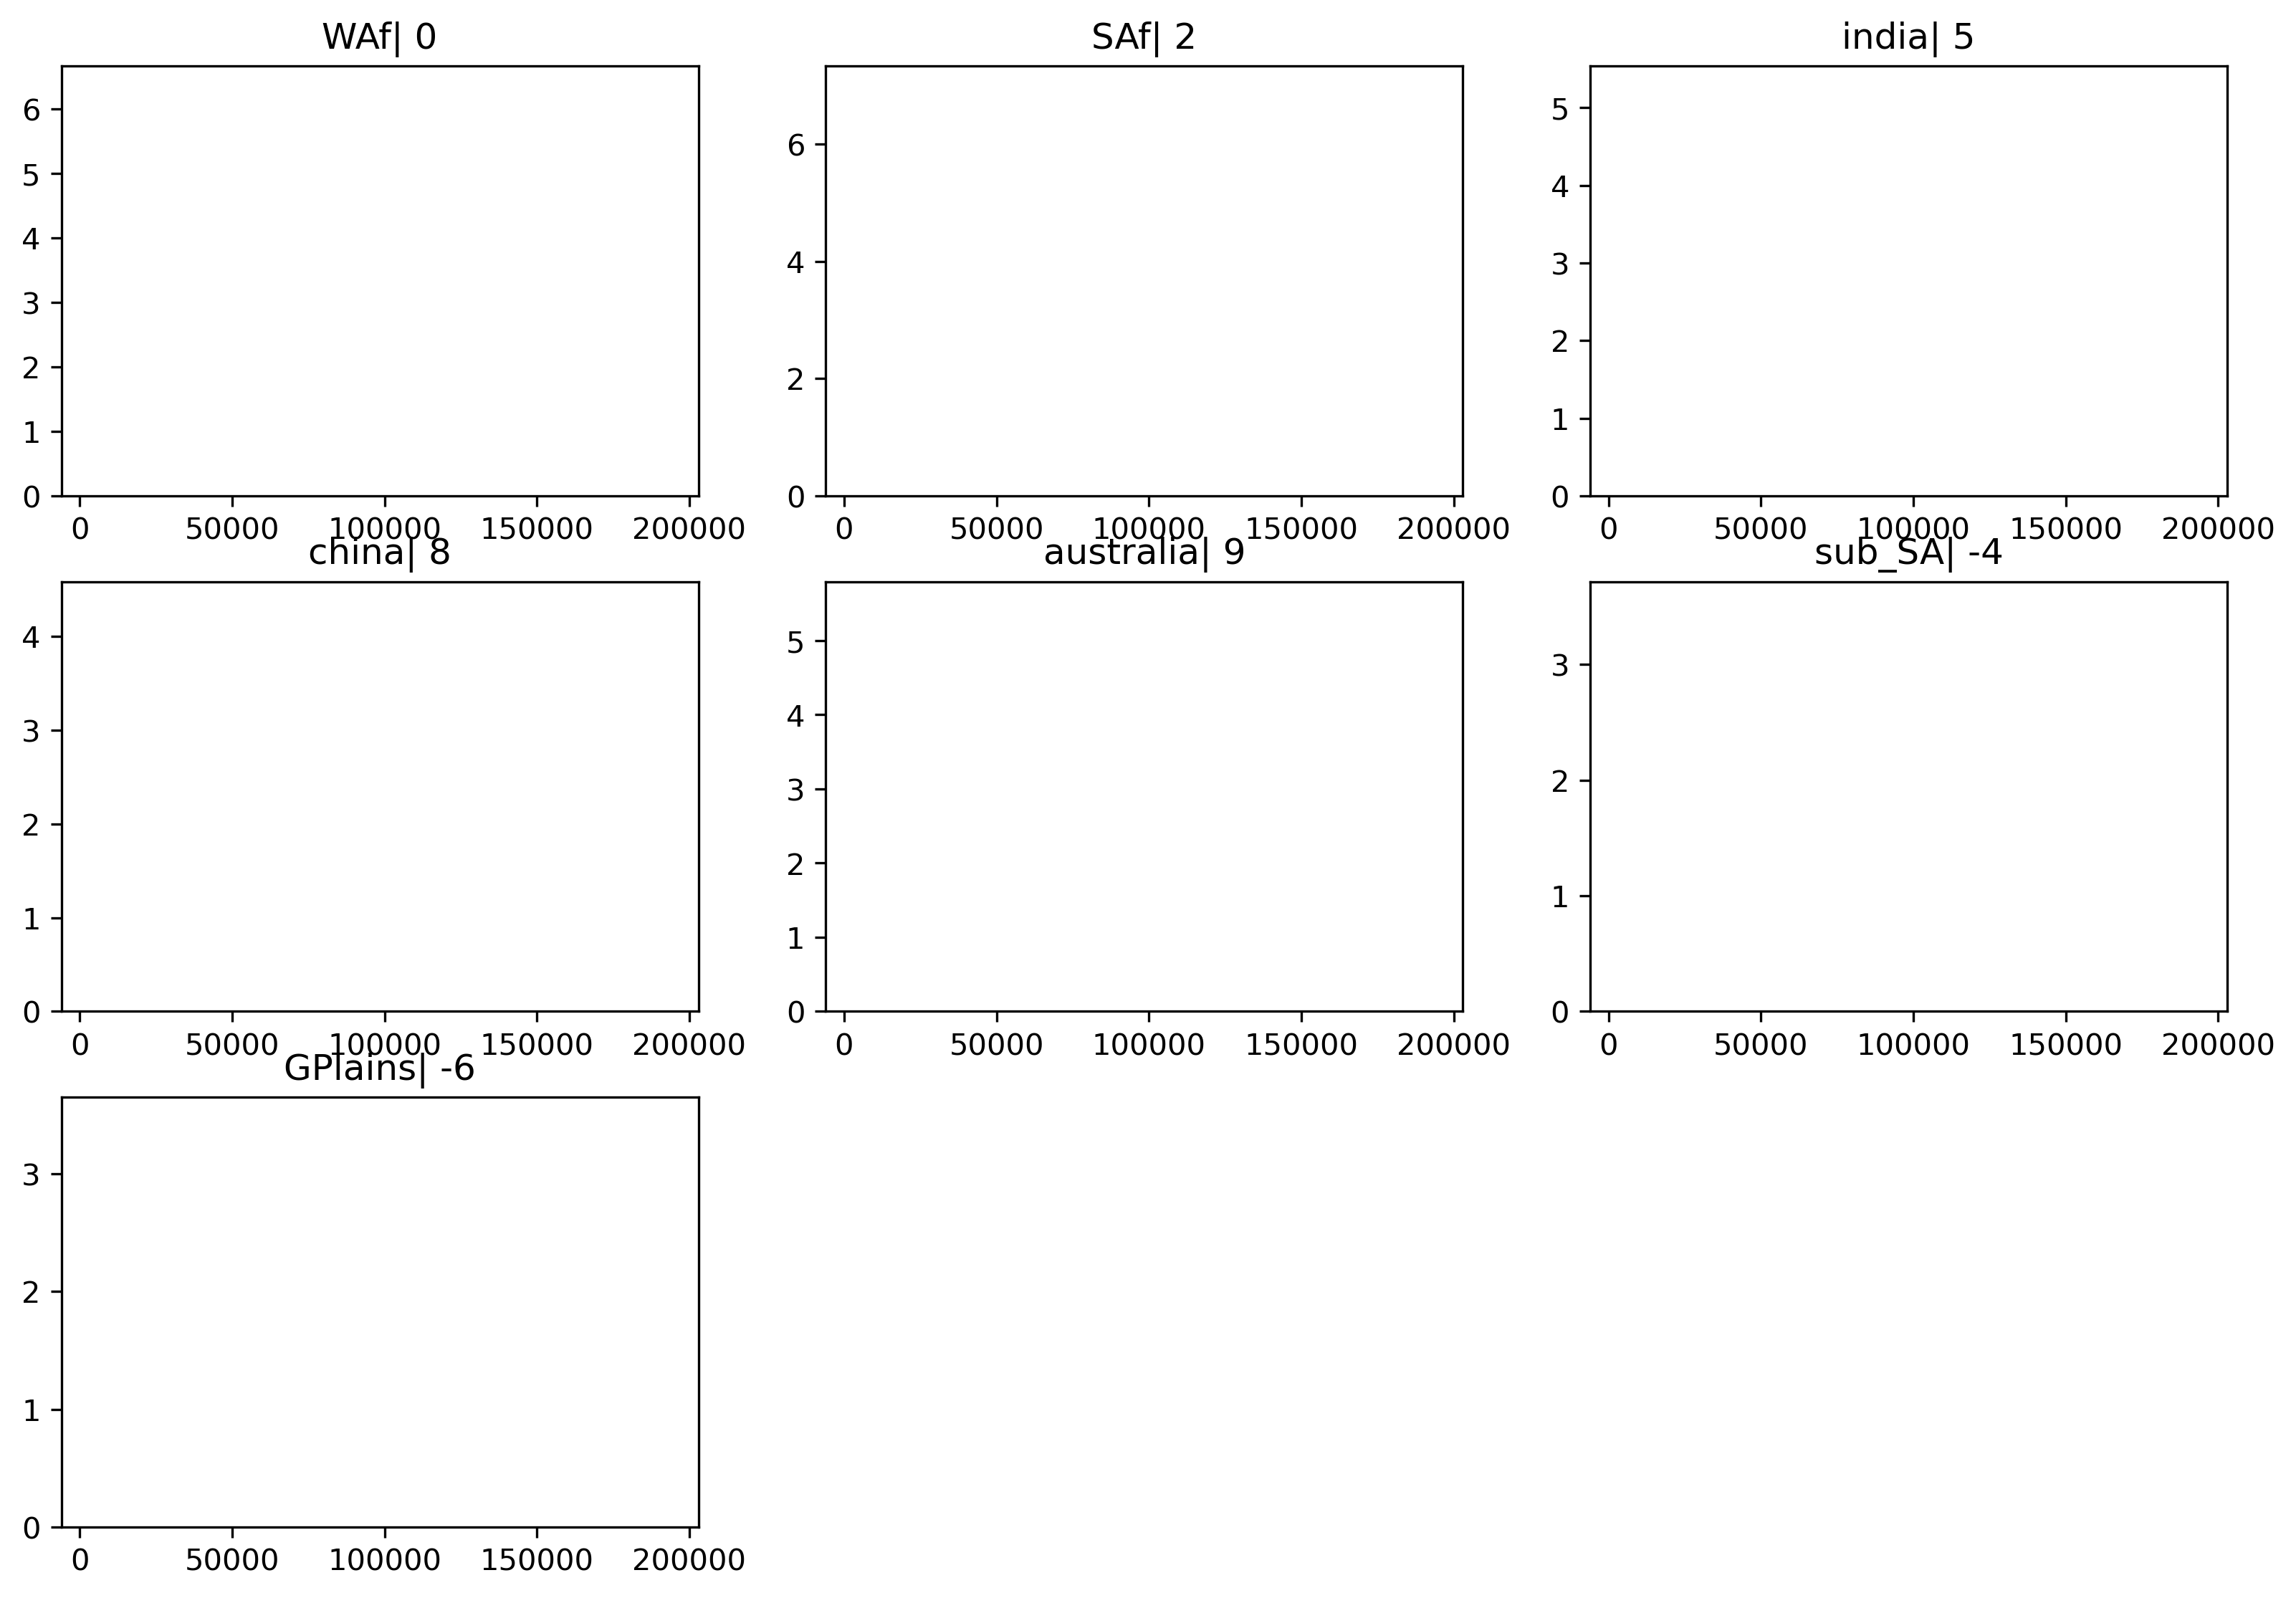

In [54]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['ccs_area'], bins=np.arange(1000,200000,5000))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
#     ispos = int(np.where(mid_bin==18.5)[0])
#     secpos = int(np.where(mid_bin==13.5)[0])
#     firstpos = int(np.where(mid_bin==10.5)[0])
#     #minpos = ispos-(MREGIONS[regs])[2]
#     #ipdb.set_trace()
#     minpos = ispos-(MREGIONS[regs])[2]
#     miinpos = firstpos - (MREGIONS[regs])[2]
#     miiinpos = secpos - (MREGIONS[regs])[2]
#     print(minpos)
#     if minpos == 24:
#         minpos=0
    
#     colors[minpos] = 'r'
#     colors[miinpos] = 'turquoise'
#     colors[miiinpos] = 'purple'
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint_dist.jpg')

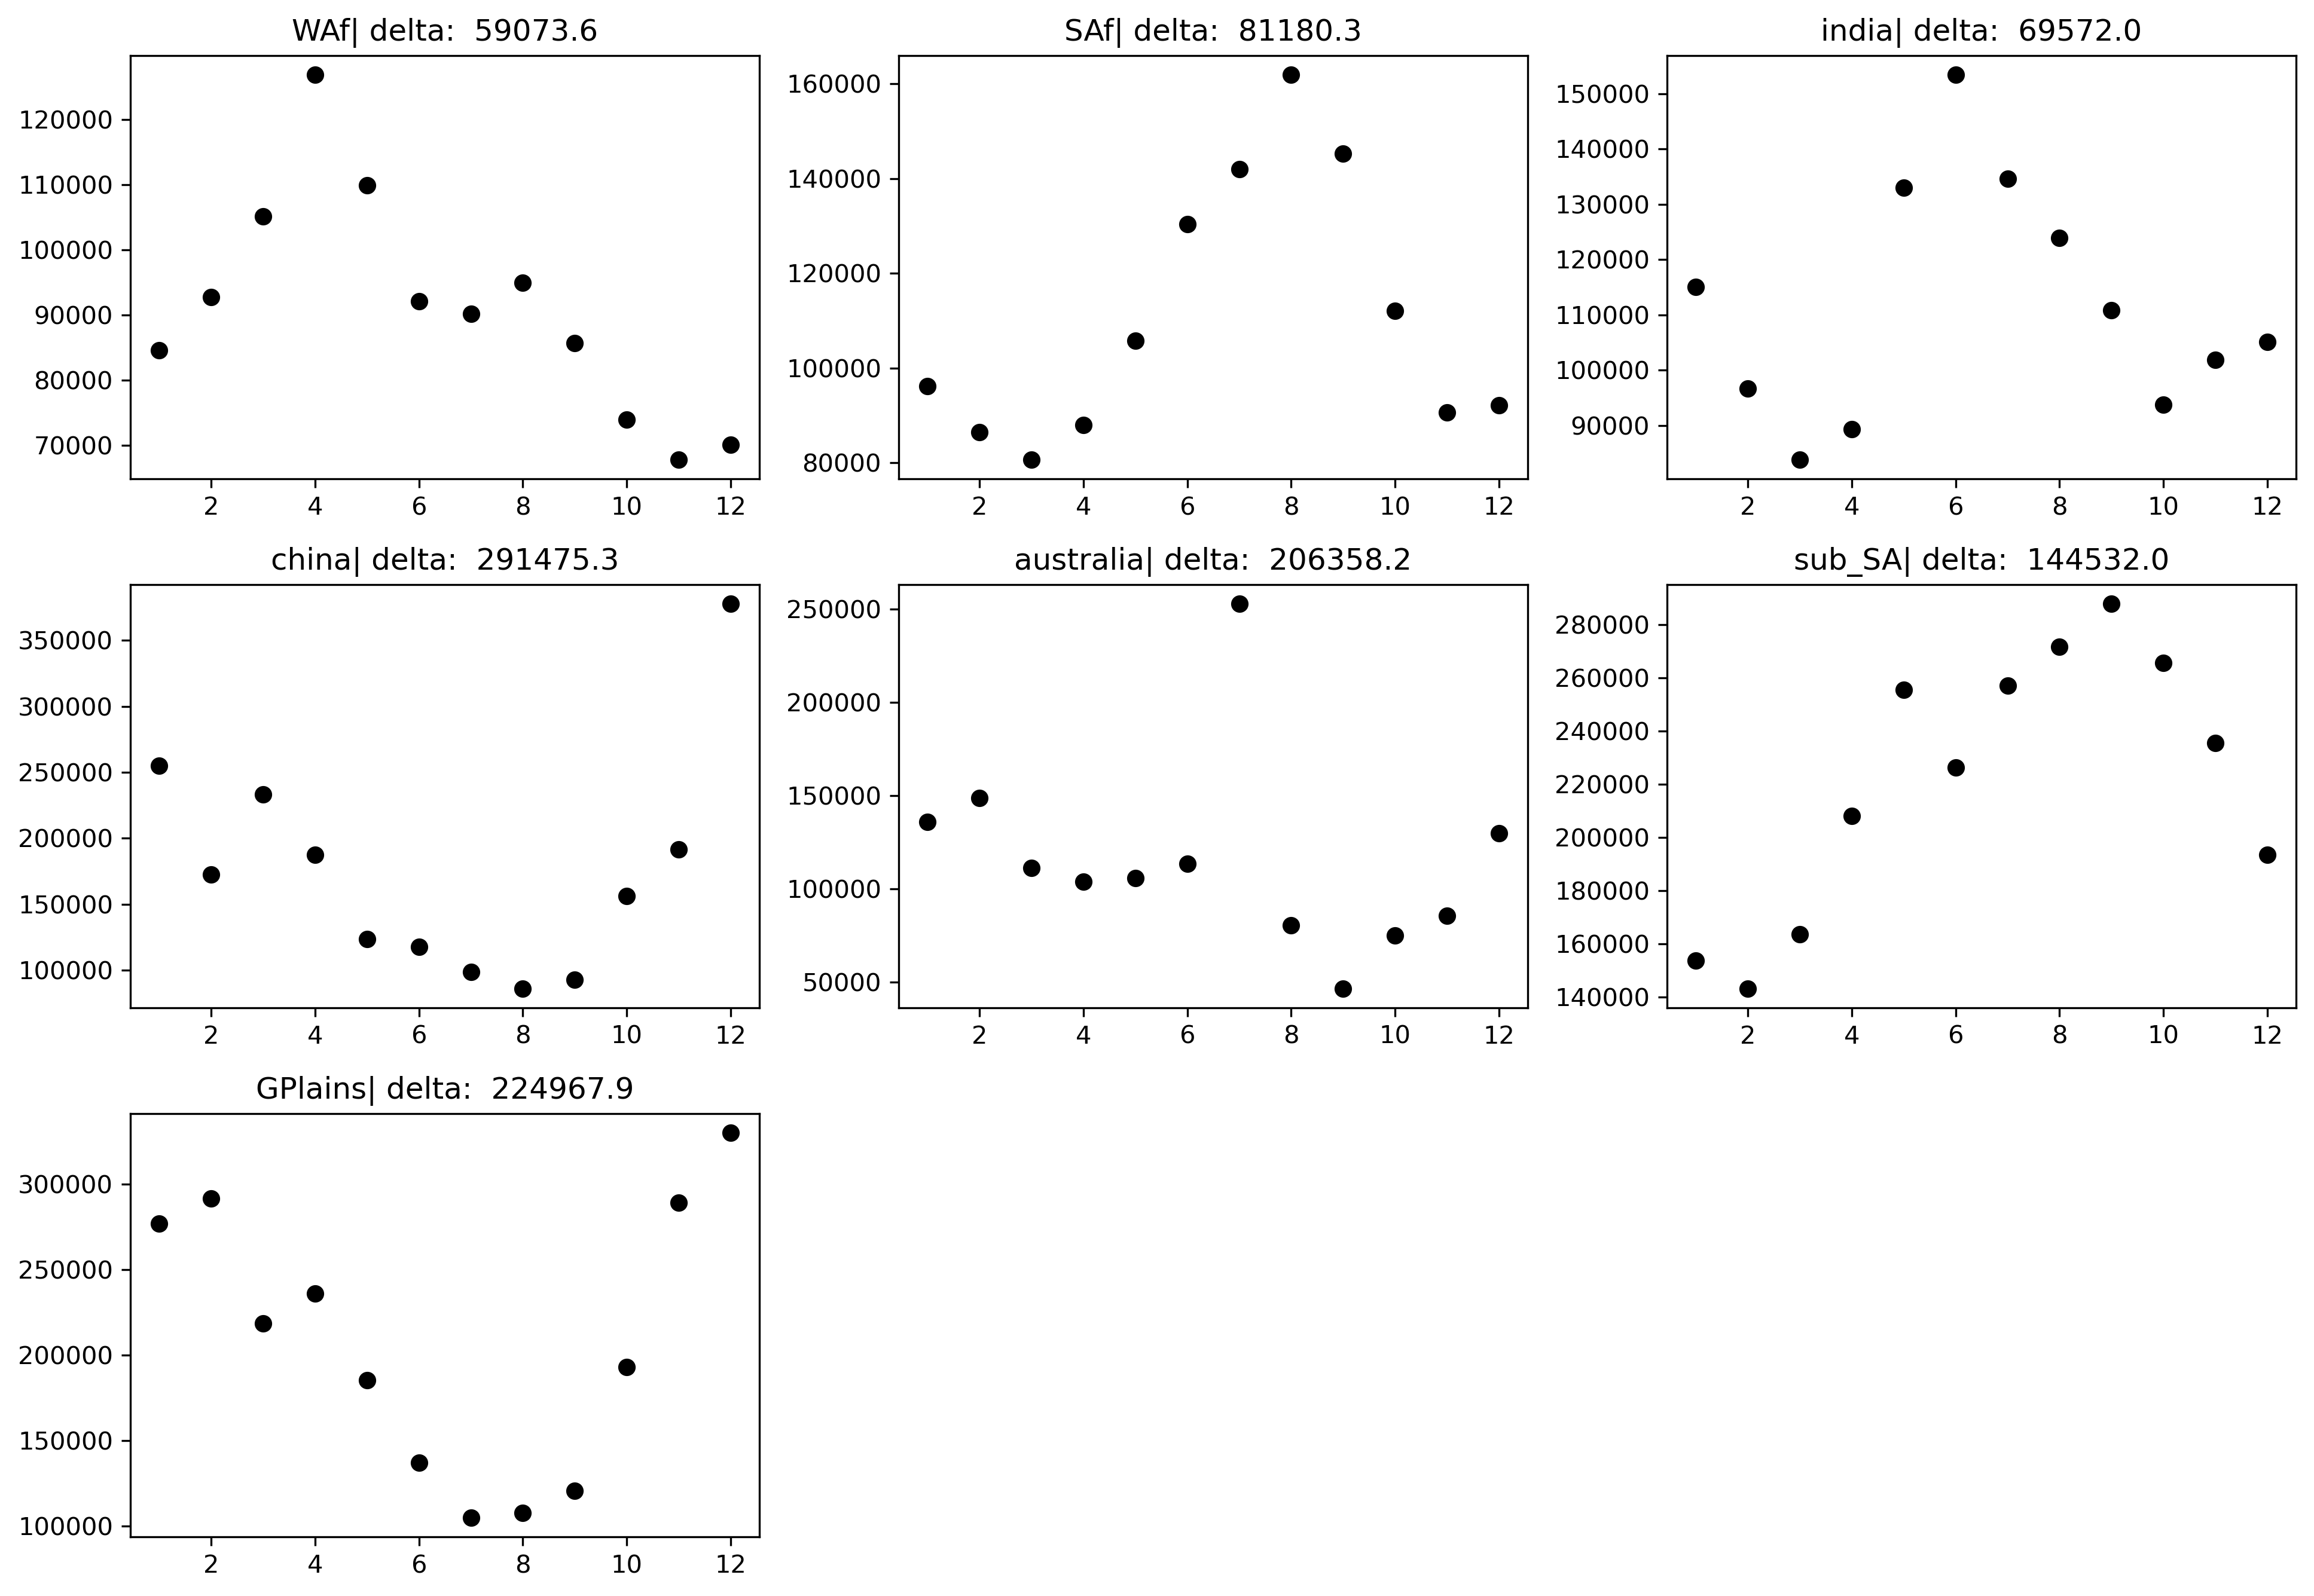

In [43]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    

    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    coll = []
    for m in range(1,13):
        pickm = pick[pick['month'] == m]
        meant =  pickm['ccs_area'].mean()
        coll.append(meant)
     
        
    ax.scatter(range(1,13),np.array(coll)-273.15, color='k')
    ax.set_title(regs + '| delta:  '+str(np.round(np.array(coll).max()-np.array(coll).min(),1)))
plt.tight_layout()
f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_area.jpg')

In [ ]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    

    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    coll = []
    for m in range(1,13):
        pickm = pick[pick['month'] == m]
        meant =  pickm['meantb'].mean()
        coll.append(meant)
     
        
    ax.scatter(range(1,13),np.array(coll)-273.15, color='k')
    ax.set_title(regs + '| delta:  '+str(np.round(np.array(coll).max()-np.array(coll).min(),1)))
plt.tight_layout()
f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_meant.jpg')

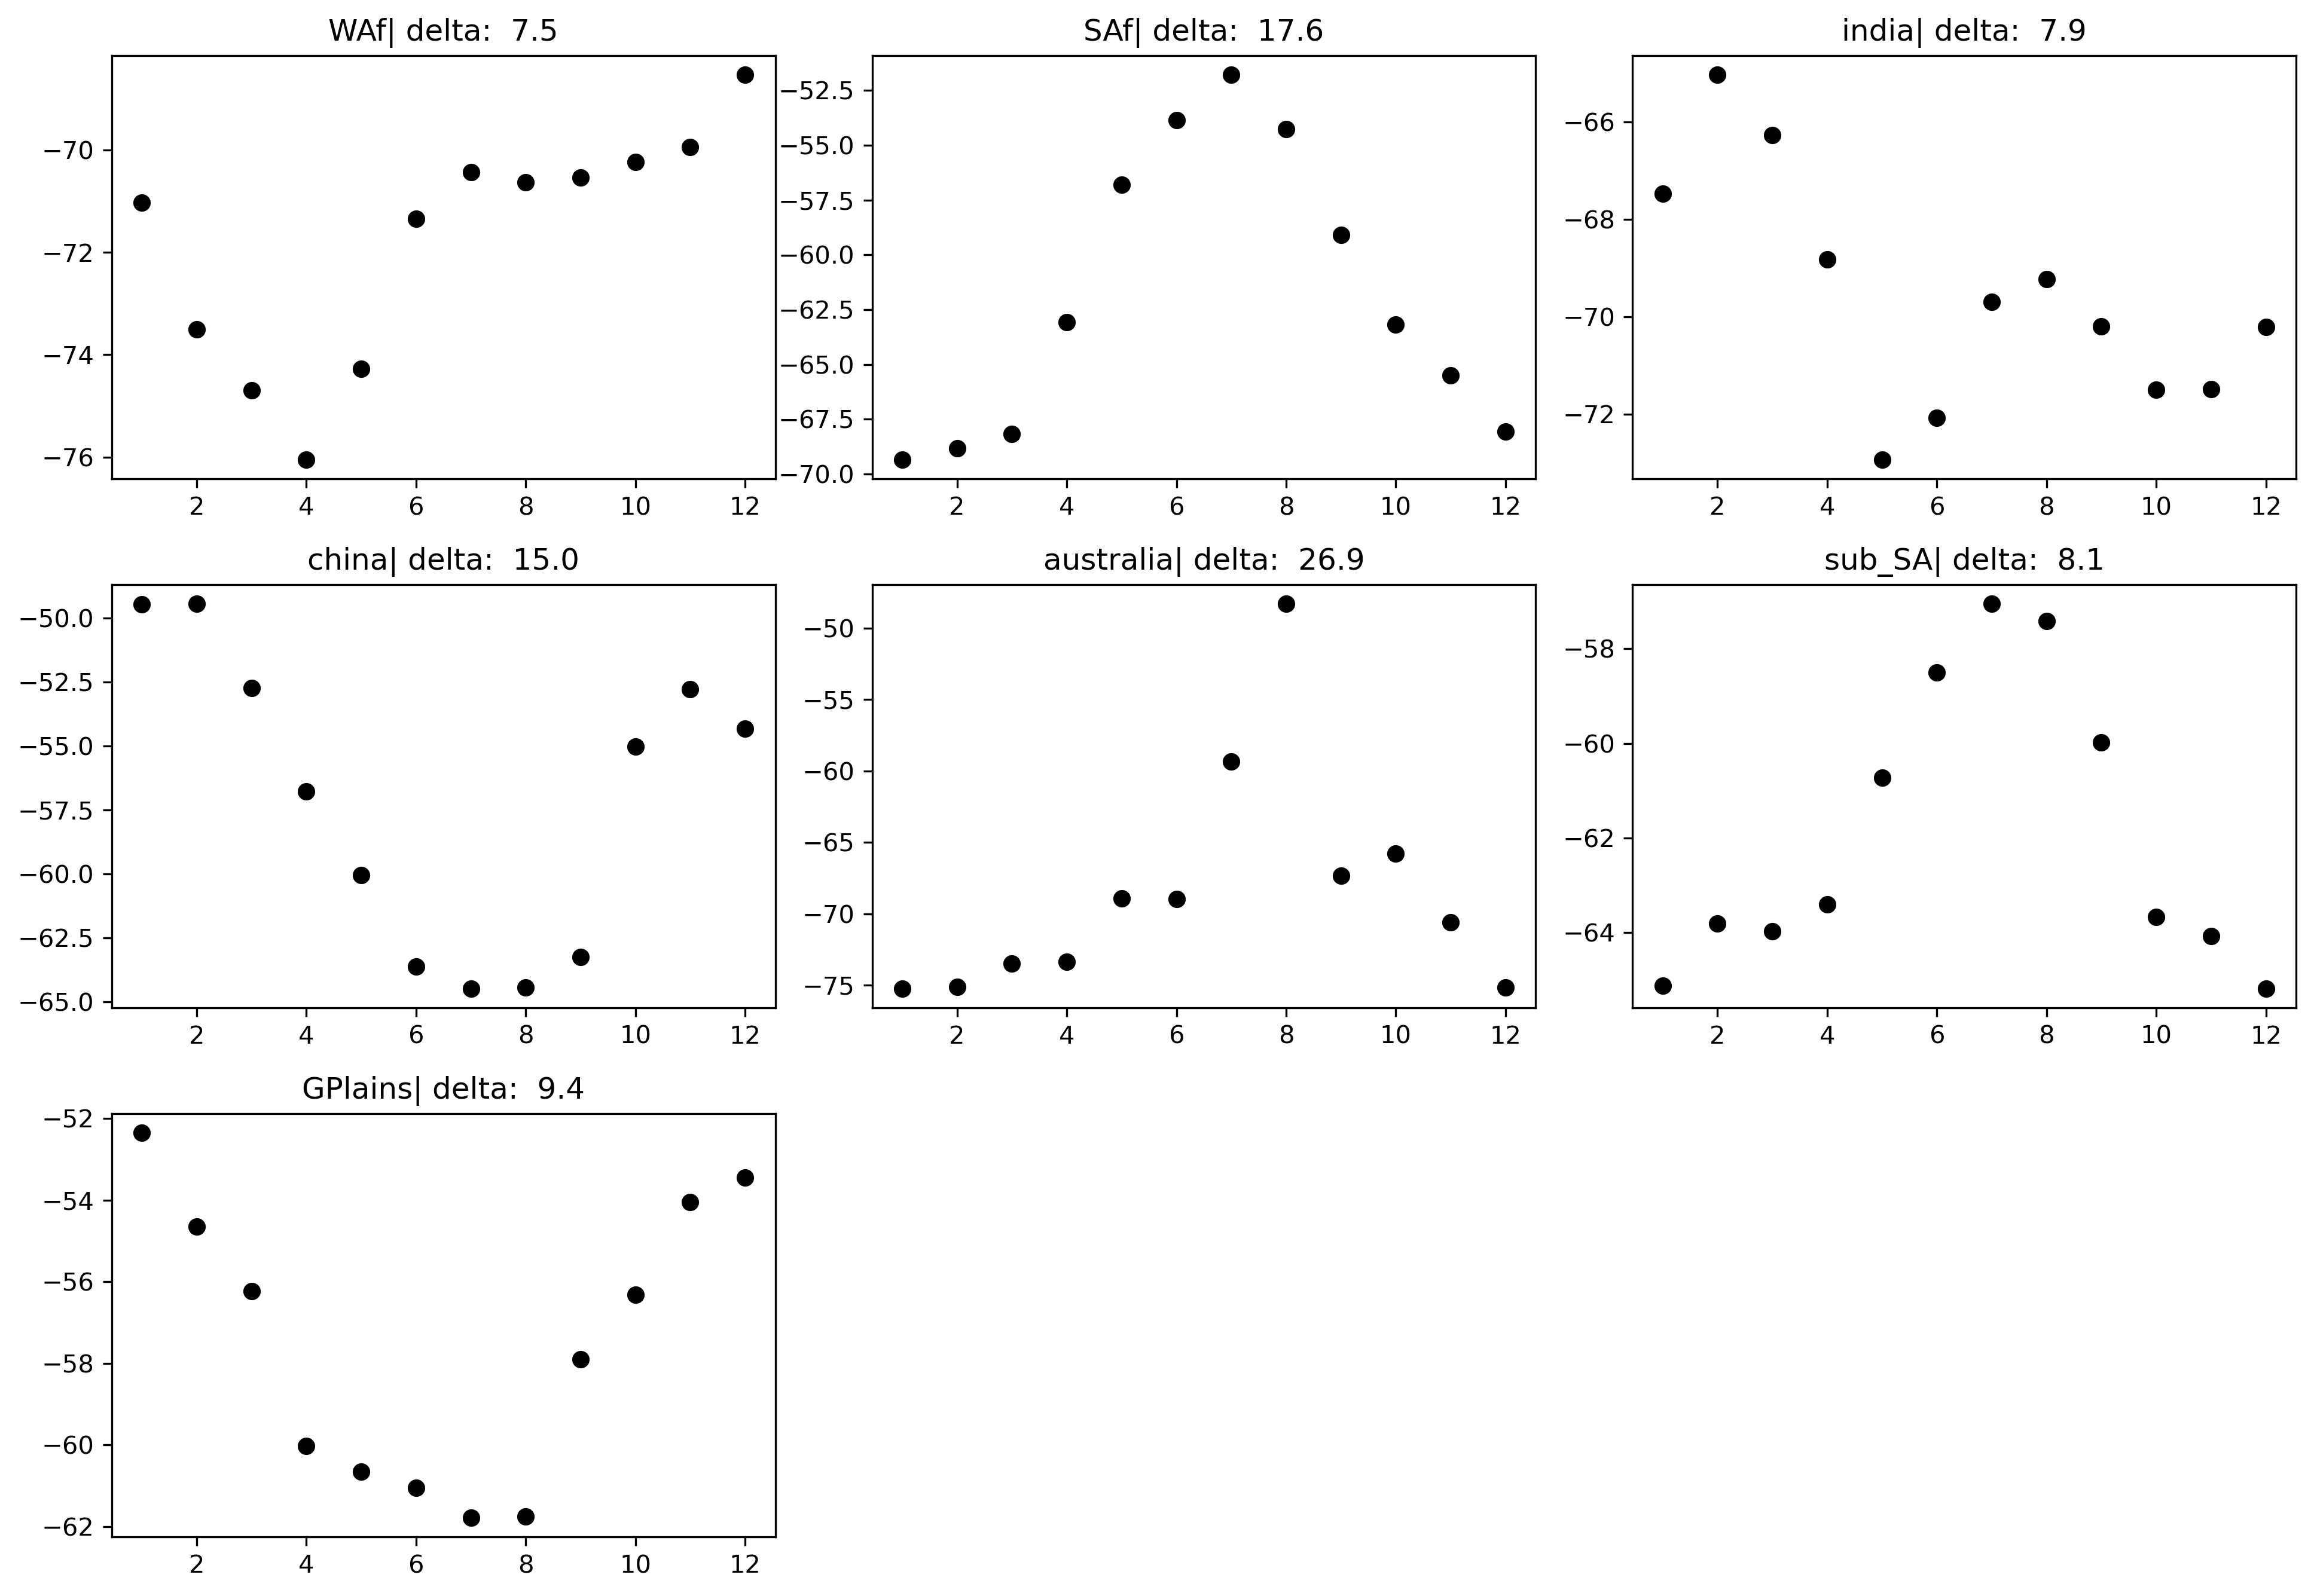

In [36]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    

    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    coll = []
    for m in range(1,13):
        pickm = pick[pick['month'] == m]
        meant =  pickm['mintb'].mean()
        coll.append(meant)
     
        
    ax.scatter(range(1,13),np.array(coll)-273.15, color='k')
    ax.set_title(regs + '| delta:  '+str(np.round(np.array(coll).max()-np.array(coll).min(),1)))
plt.tight_layout()
f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint.jpg')

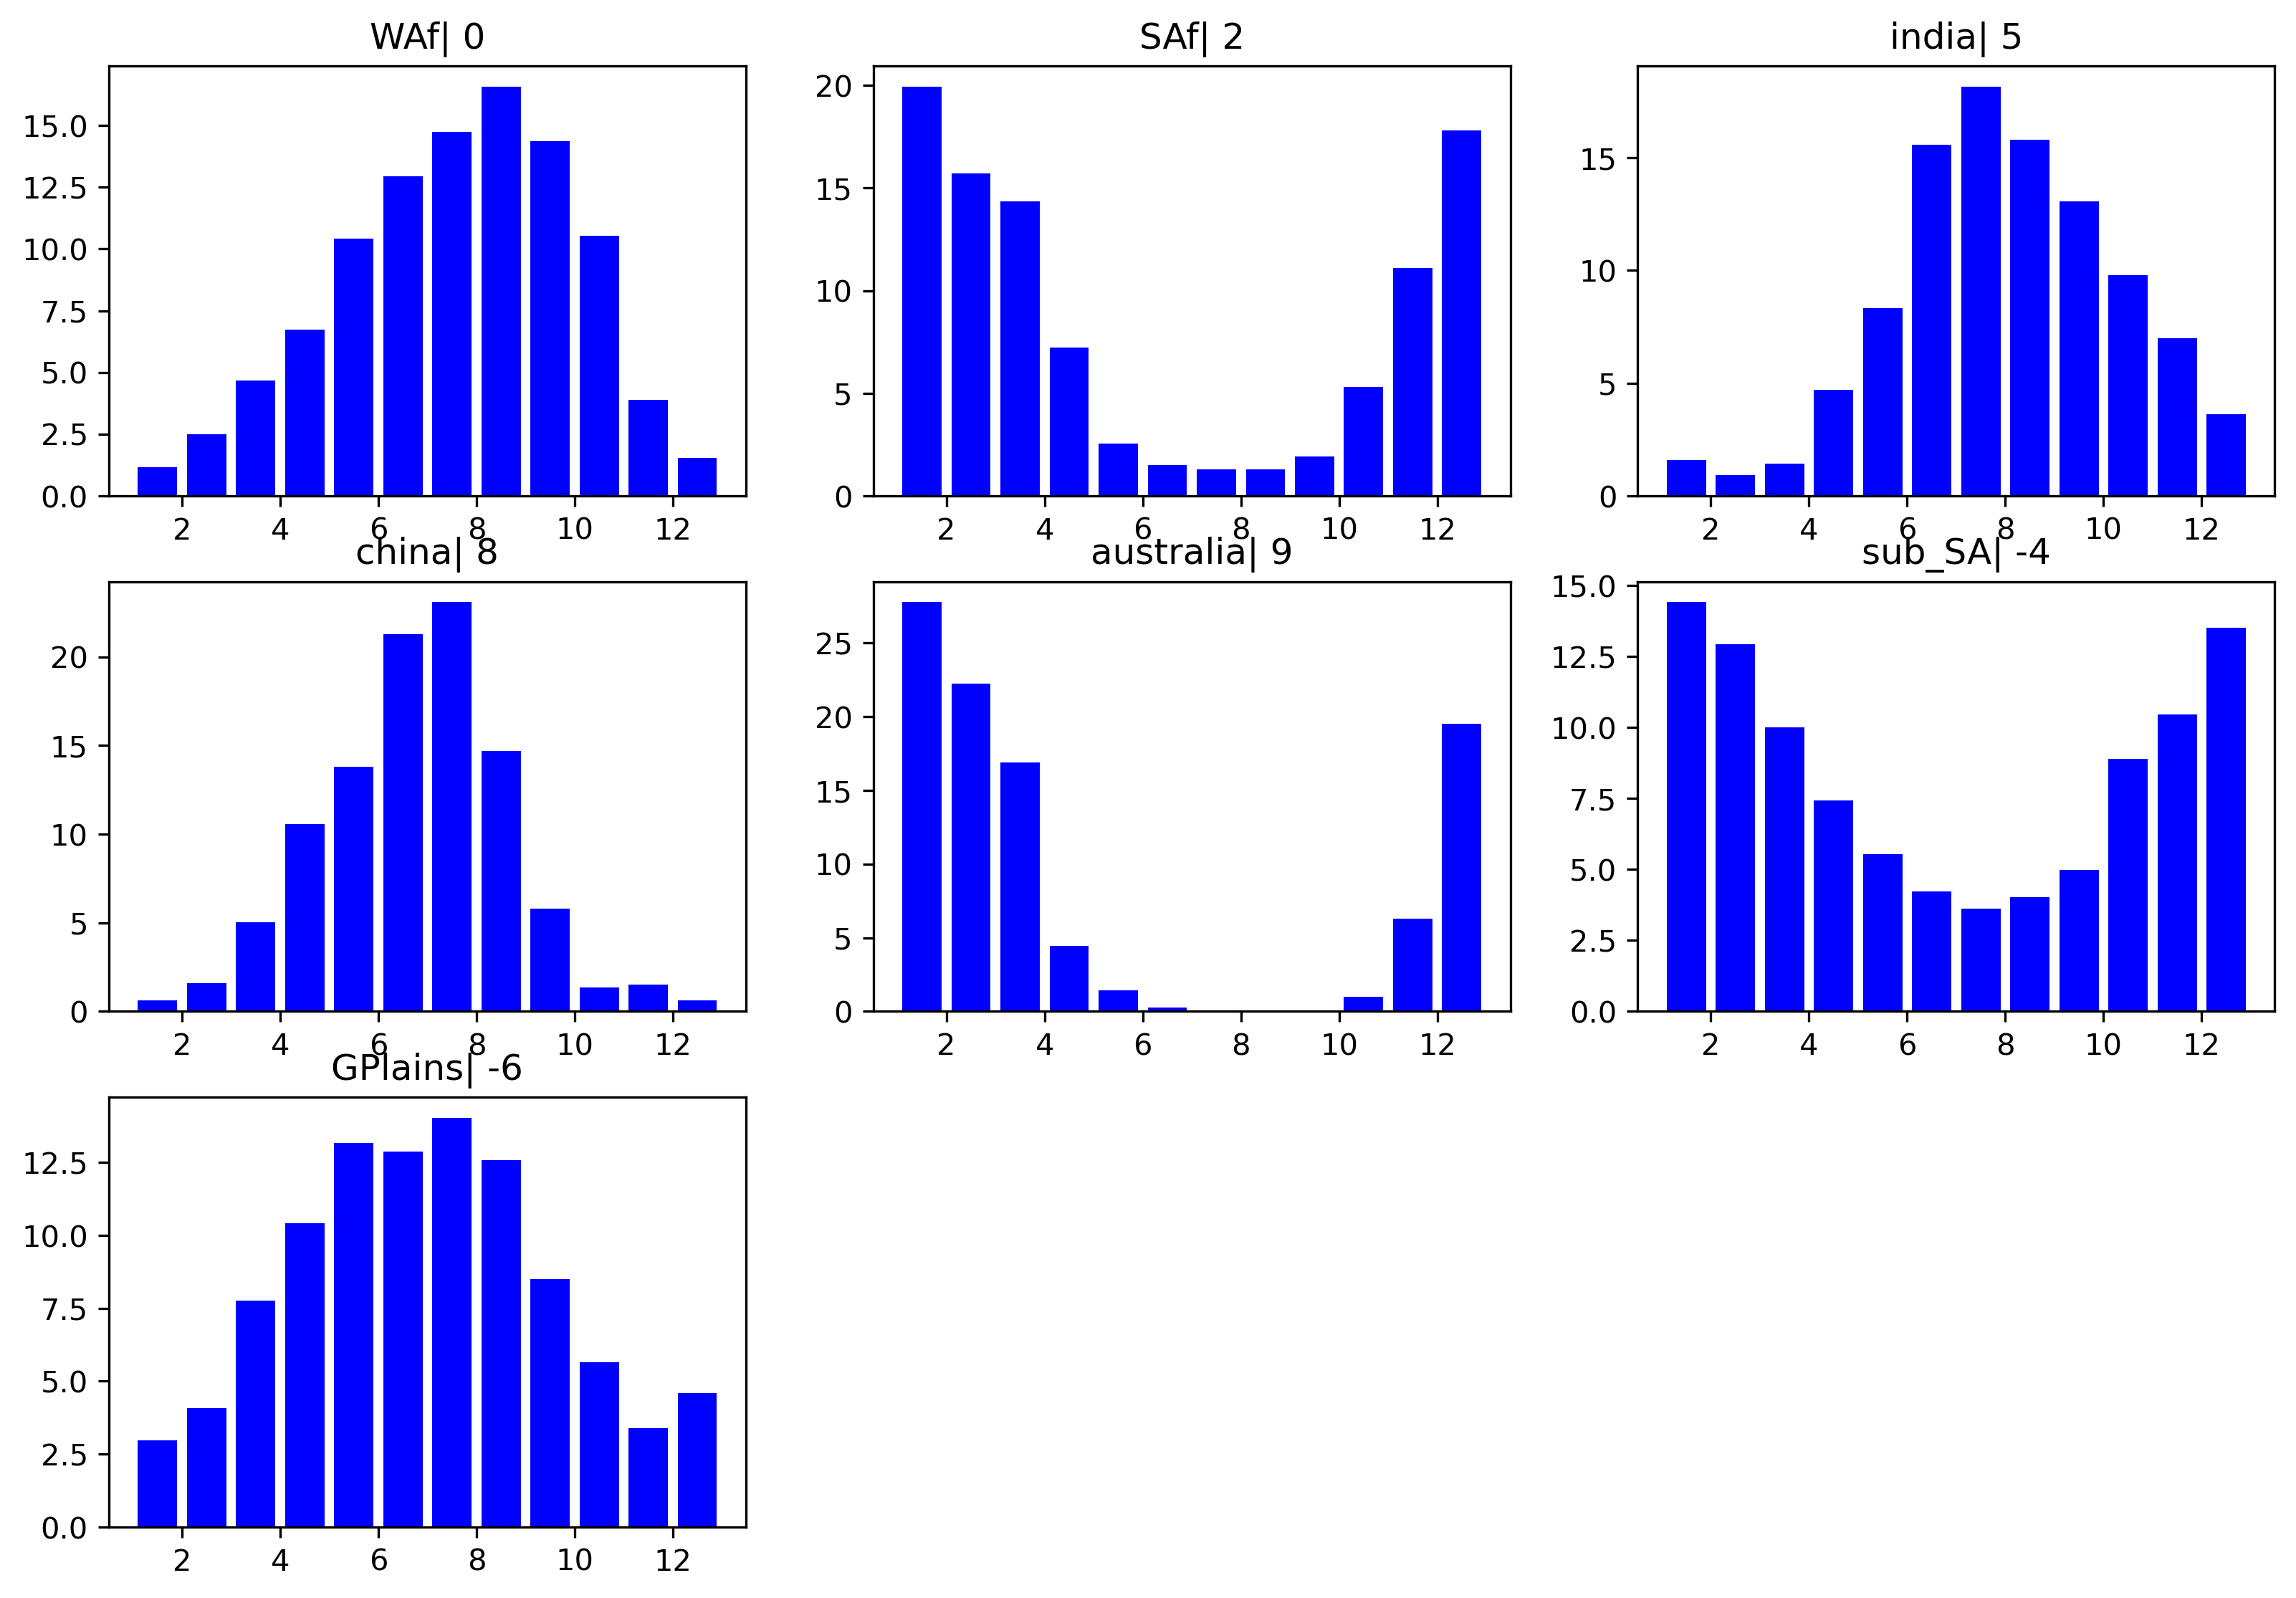

In [41]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['month'], bins=np.arange(1,14))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
#     ispos = int(np.where(mid_bin==18.5)[0])
#     secpos = int(np.where(mid_bin==13.5)[0])
#     firstpos = int(np.where(mid_bin==10.5)[0])
#     #minpos = ispos-(MREGIONS[regs])[2]
#     #ipdb.set_trace()
#     minpos = ispos-(MREGIONS[regs])[2]
#     miinpos = firstpos - (MREGIONS[regs])[2]
#     miiinpos = secpos - (MREGIONS[regs])[2]
#     print(minpos)
#     if minpos == 24:
#         minpos=0
    
#     colors[minpos] = 'r'
#     colors[miinpos] = 'turquoise'
#     colors[miiinpos] = 'purple'
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_stormNB.jpg')

18
16
13
10
9
22
24


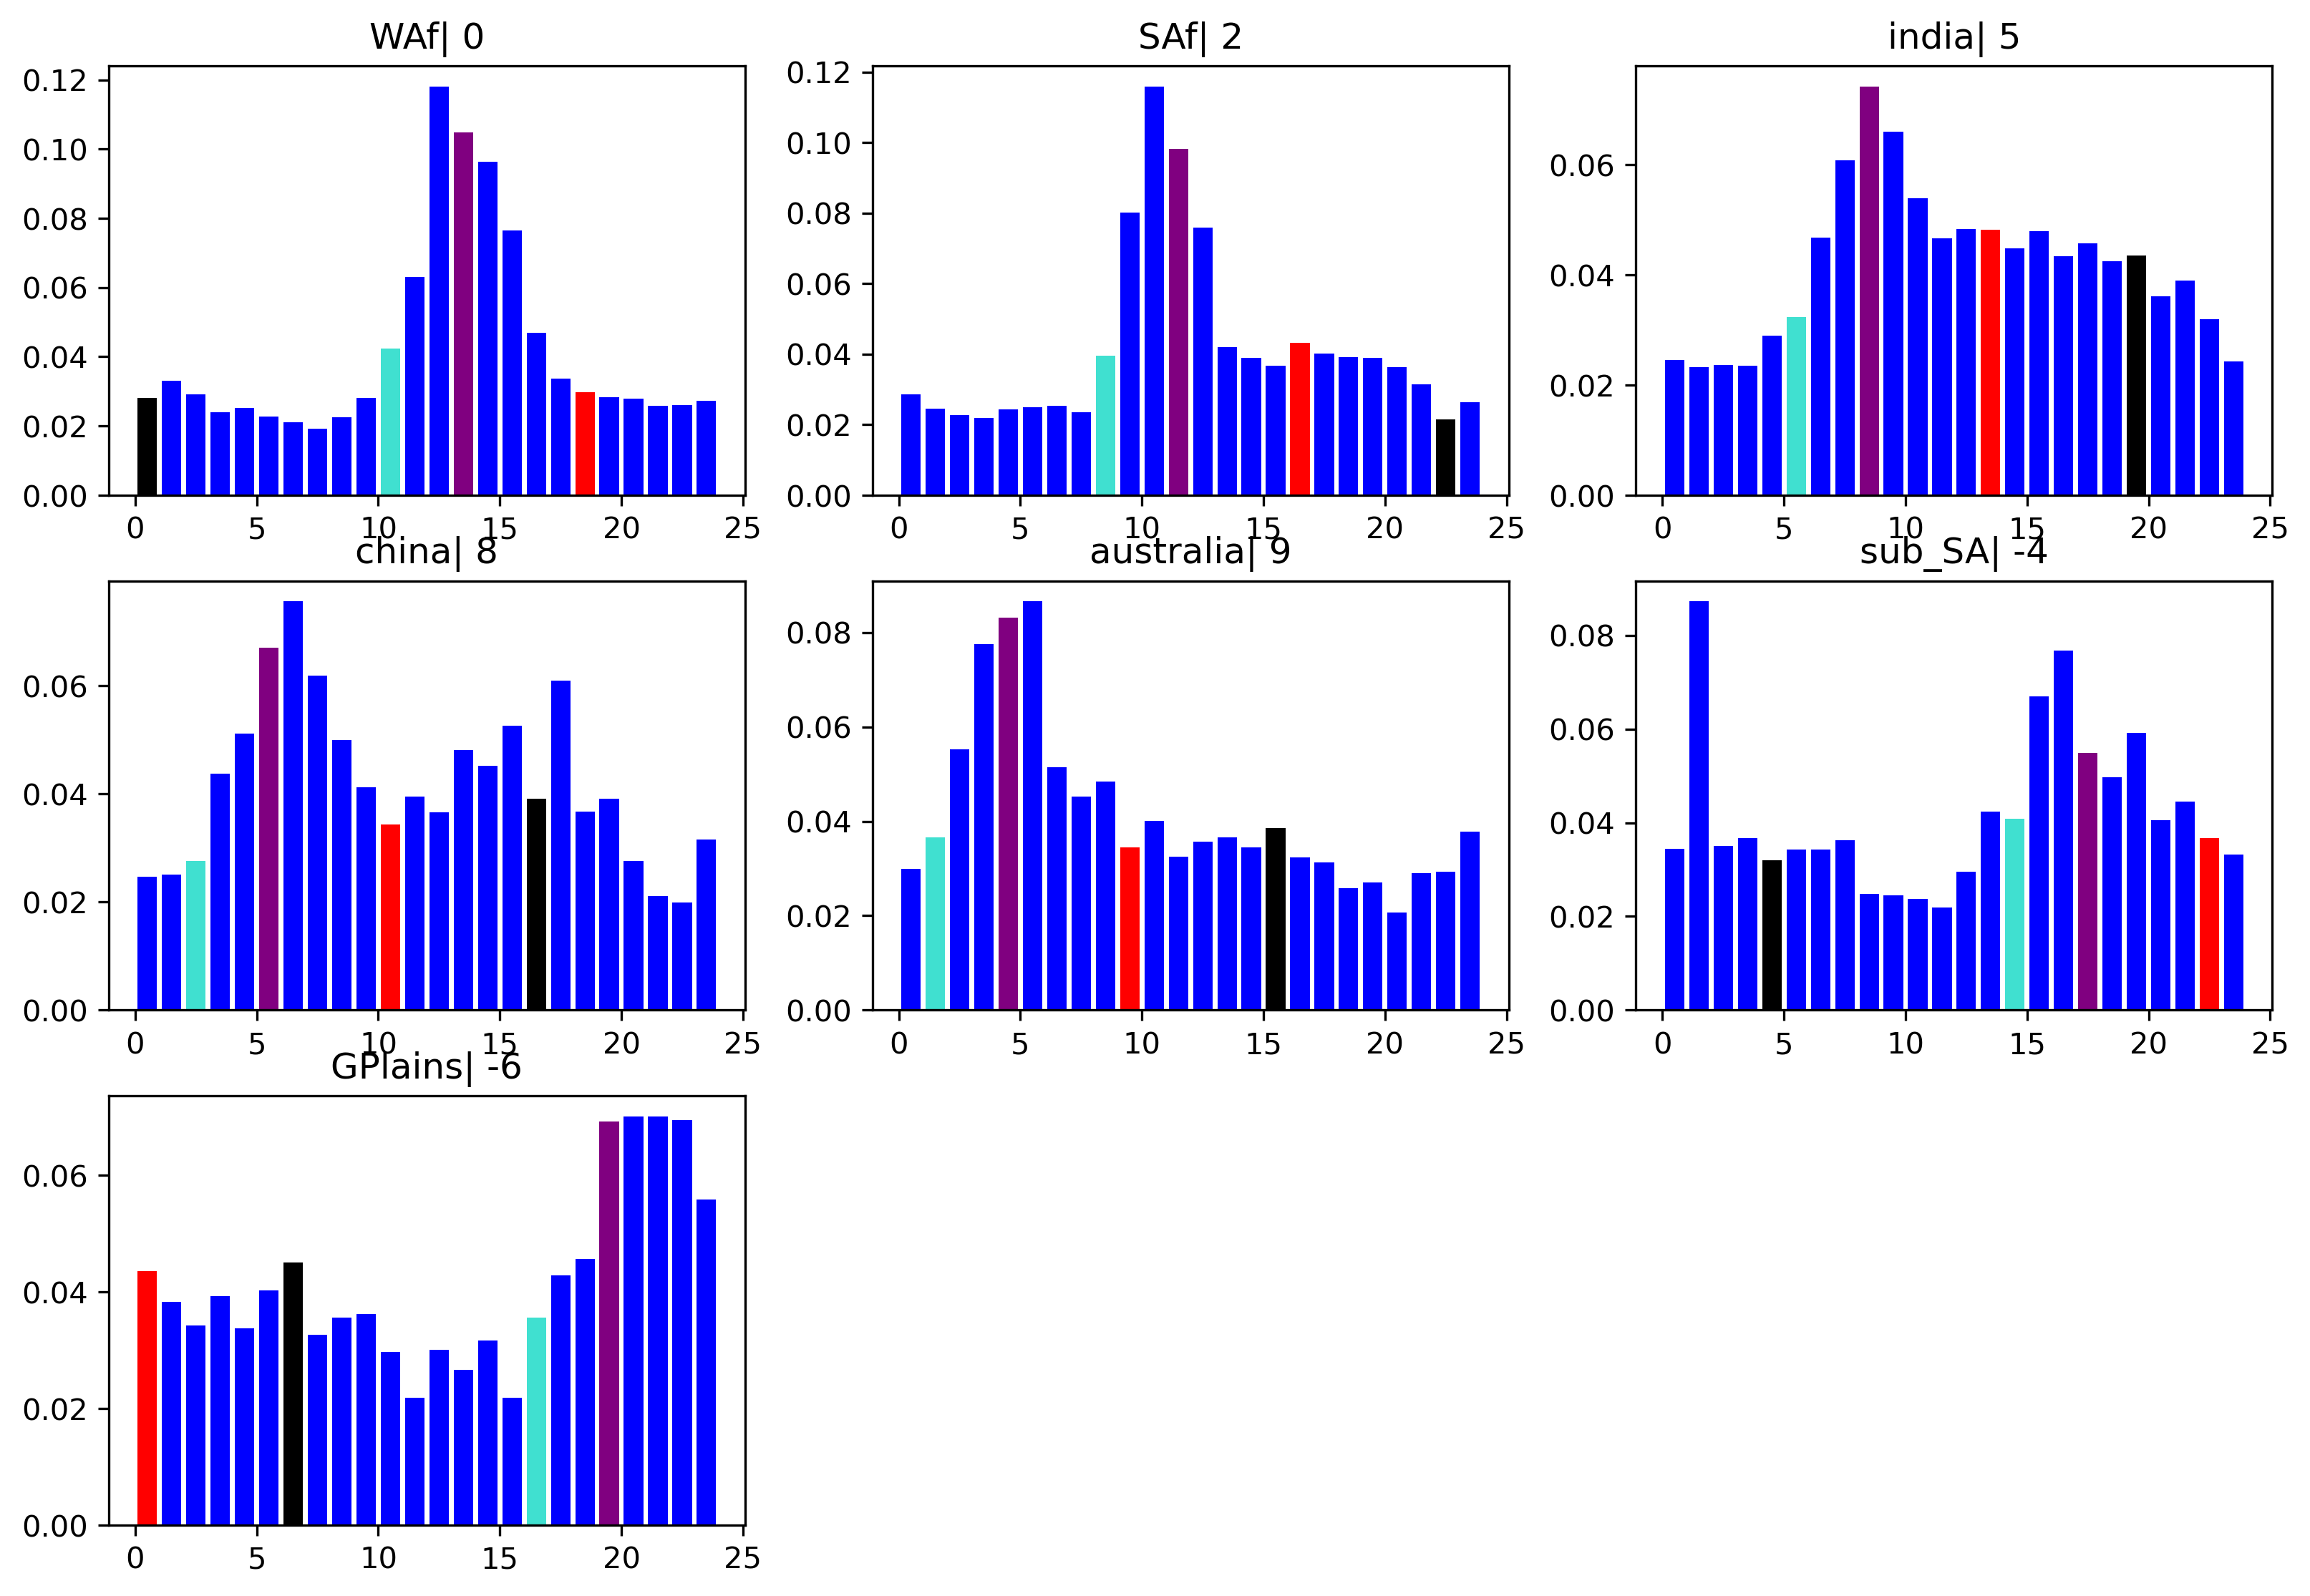

In [14]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['init_hour'], bins=np.arange(0,25))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
    ispos = int(np.where(mid_bin==18.5)[0])
    secpos = int(np.where(mid_bin==13.5)[0])
    firstpos = int(np.where(mid_bin==10.5)[0])
    thirdpos = int(np.where(mid_bin==0.5)[0])
    #minpos = ispos-(MREGIONS[regs])[2]
    #ipdb.set_trace()
    minpos = ispos-(MREGIONS[regs])[2]
    miinpos = firstpos - (MREGIONS[regs])[2]
    miiinpos = secpos - (MREGIONS[regs])[2]
    midnightpos = thirdpos - (MREGIONS[regs])[2]
    print(minpos)
    if minpos == 24:
        minpos=0
    
    colors[minpos] = 'r'
    colors[miinpos] = 'turquoise'
    colors[miiinpos] = 'purple'
    colors[midnightpos] = 'k'
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
